# GSDAE (Group Selective Deep AutoEncoder) for Danshen Analysis

基于方案文档的改进版本，包含：
1. 组稀疏正则化 (Group Lasso)
2. 半监督学习机制
3. 预测头 (Prediction Head)
4. 复合损失函数
5. 两层重要性分析

## 环境与库导入：标准科学栈 + TensorFlow + keras_tuner（但后续未真正使用调参逻辑）。

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import json
import math
import re
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import glob

import seaborn as sns  # 新增

from sklearn.preprocessing import StandardScaler
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import optimizers, initializers
from tensorflow.keras.callbacks import TerminateOnNaN, ReduceLROnPlateau

import keras_tuner as kt

## Data Loading and Preprocessing

## 数据加载与合并：遍历目录下多个 CSV，分离目标列，按样本 ID 内连接合并特征。

In [2]:
# --- 1. 定义特征文件所在的目录 ---
feature_files_dir = './data_R/EnvironmentGroup/'
sample_id_col = 'SampleN' # <--- 假设每个文件里都有这个样本ID列

# --- 2. 查找所有特征文件 ---
csv_files = glob.glob(os.path.join(feature_files_dir, '*.csv'))
if not csv_files:
    raise FileNotFoundError(f"在目录 '{feature_files_dir}' 中没有找到任何CSV文件。")

print(f"找到了 {len(csv_files)} 个特征文件。")

# --- 3. 从第一个文件中获取目标变量 ---
try:
    first_df = pd.read_csv(csv_files[0])
    # 假设目标变量是最后一列
    target_column_name = first_df.columns[-1]
    # 提取目标变量和样本ID，并设置索引
    main_target = first_df[[sample_id_col, target_column_name]].set_index(sample_id_col)
    print(f"目标变量 '{target_column_name}' 已从 '{os.path.basename(csv_files[0])}' 中分离。")
except (IndexError, KeyError) as e:
    raise ValueError(f"无法从文件 {csv_files[0]} 中提取目标变量或样本ID: {e}")

# --- 4. 循环读取所有文件，合并特征 ---
all_feature_dfs = []
for file_path in csv_files:
    try:
        # 读取数据，并将样本ID设为索引
        df = pd.read_csv(file_path).set_index(sample_id_col)
        # 删除目标列，只保留特征
        features_only = df.drop(columns=[target_column_name])

        # 如果是 physicochemical.csv，删除指定字段
        if os.path.basename(file_path).lower() == 'physicochemical.csv':
            cols_to_remove = ['NH4_N', 'NO3_N', 'N.N', 'TN', 'OM']
            # 大小写兼容匹配
            remove_map = {c.lower(): c for c in features_only.columns}
            real_remove = [remove_map[c.lower()] for c in cols_to_remove if c.lower() in remove_map]
            if real_remove:
                features_only = features_only.drop(columns=real_remove, errors='ignore')
                print(f"已从 physicochemical.csv 删除字段: {real_remove}")

        all_feature_dfs.append(features_only)
    except (FileNotFoundError, KeyError) as e:
        print(f"警告：处理文件 {file_path} 时出错，已跳过。错误: {e}")

# --- 5. 合并所有特征 ---
# 使用 outer join 以保留所有样本，缺失处会用NaN填充
# 使用 inner join 只保留所有文件中都存在的样本
feature_data = pd.concat(all_feature_dfs, axis=1, join='inner')

# --- 6. 对齐特征和目标 ---
# 确保 feature_data 和 main_target 的样本索引一致
common_samples = feature_data.index.intersection(main_target.index)
feature_data = feature_data.loc[common_samples]
main_target = main_target.loc[common_samples]

print(f"\n合并后的特征数据形状: {feature_data.shape}")
print(f"对齐后的目标变量形状: {main_target.shape}")

找到了 4 个特征文件。
目标变量 'SumTS' 已从 'climate.csv' 中分离。
已从 physicochemical.csv 删除字段: ['NH4_N', 'NO3_N', 'N.N', 'TN', 'OM']

合并后的特征数据形状: (991, 64)
对齐后的目标变量形状: (991, 1)


## 预处理：列缺失率阈值过滤 + 行级完整性过滤 + 类别特征独热编码 + 标准化（X 与 y 都用 StandardScaler）。

In [3]:
# --- 数据预处理 ---
# 1. 处理缺失值：删除特征超过50%缺失的列
thresh = len(feature_data) * 0.5
feature_data = feature_data.dropna(axis=1, thresh=thresh)

# 2. 处理缺失值：删除任何包含缺失值的行（样本）
# 首先合并，然后删除带有任何NaN的行，最后再分开，以确保对齐
temp_df = pd.concat([feature_data, main_target], axis=1)
temp_df.dropna(inplace=True)

# 重新分离
feature_data = temp_df.drop(columns=main_target.columns)
main_target = temp_df[main_target.columns]

# 3. 独热编码
categorical_columns = ["Province", "City", "Microb", "Landscape", "SoilType", "soilclass", "CultivationType", "ClimateType", "按气候聚类划分的类型"]
categorical_columns = [col for col in categorical_columns if col in feature_data.columns]
if categorical_columns:
    feature_data = pd.get_dummies(feature_data, columns=categorical_columns, drop_first=True)

print(f"预处理后特征数据形状: {feature_data.shape}")
print(f"预处理后目标变量形状: {main_target.shape}")

预处理后特征数据形状: (983, 67)
预处理后目标变量形状: (983, 1)


In [4]:
# 数据分割和标准化
X_train, X_test, y_train, y_test = train_test_split(feature_data, main_target, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scal = scaler_X.fit_transform(X_train)
X_test_scal = scaler_X.transform(X_test)
y_train_scal = scaler_y.fit_transform(y_train)
y_test_scal = scaler_y.transform(y_test)

# --- 新增：提前反标准化 y_test，为后续评估做准备 ---
y_test_orig = scaler_y.inverse_transform(y_test_scal)

feature_names = list(feature_data.columns)
print(f"训练集: {X_train_scal.shape}, 测试集: {X_test_scal.shape}")
print(f"特征总数: {len(feature_names)}")

训练集: (786, 67), 测试集: (197, 67)
特征总数: 67


## Feature Grouping

## 特征分组：三种模式 external/custom/auto；当前默认 external 读取目录列名映射到现有特征索引，再无结果则回退 auto 启发式。

In [5]:
# ...existing code...
def _find_indices_by_names(feature_names, names_list):
    """在 feature_names 中匹配 names_list（支持精确/包含/前缀），返回索引列表（去重、有序）"""
    fn_lower = [f.lower() for f in feature_names]
    indices = []
    names_lower = [n.lower() for n in names_list]
    for i, fname in enumerate(fn_lower):
        for nm in names_lower:
            if fname == nm or nm in fname or fname.startswith(nm) or fname.endswith(nm):
                indices.append(i)
                break
    return sorted(set(indices))

def create_feature_groups(feature_names, method='external', external_dir='./data_R/EnvironmentGroup', custom_groups=None):
    """
    创建特征分组。
    method: 'external'|'custom'|'auto'
      - 'external'：从 external_dir 中读取所有 csv 文件（每个文件视为一组，使用列名映射）
      - 'custom'：使用 custom_groups 字典 {group_name: [names_or_substrings,...]}
      - 'auto'：使用启发式规则（原始逻辑）
    返回: dict {group_name: [indices,...]}
    """
    feature_names = list(feature_names)
    groups = {}

    if method == 'external':
        # 找到目录下的 csv 文件
        if os.path.exists(external_dir):
            csv_files = sorted(glob.glob(os.path.join(external_dir, '*.csv')))
            for fp in csv_files:
                gname = os.path.splitext(os.path.basename(fp))[0]
                try:
                    df = pd.read_csv(fp)
                except Exception:
                    continue
                # 常见情况：文件里有 SampleN 列，去掉
                cols = [c for c in df.columns if c.lower() not in ('samplen', 'sample_n', 'sampleid', 'sample_id')]
                # 如果文件包含目标列（如 SumTS），自动剔除
                cols = [c for c in cols if c not in ('SumTS', 'SumTS'.lower())]
                idxs = _find_indices_by_names(feature_names, cols)
                if idxs:
                    groups[gname] = idxs
        # 如果没有读取到任何组，回退到 auto
        if not groups:
            method = 'auto'

    if method == 'custom' and custom_groups:
        for gname, name_list in custom_groups.items():
            idxs = _find_indices_by_names(feature_names, name_list)
            if idxs:
                groups[gname] = idxs
        # allow fall back to auto if empty
        if not groups:
            method = 'auto'

    if method == 'auto':
        # 原始启发式规则的改进版本
        ee_elements = {'mn', 'cu', 'fe', 'zn', 'mg', 'k', 'ca', 'mo'}
        be_elements = {'v', 'na', 'co'}
        hm_elements = {'pb', 'cr', 'cd', 'as', 'sb', 'sn'}
        re_elements = {'y', 'la', 'ce', 'pr', 'nd', 'sm', 'eu', 'gd', 'tb', 'dy', 'ho', 'er', 'yb', 'th'}
        oe_elements = {'ga', 'rb', 'li', 'sr', 'ba', 'be', 'cs', 'ni', 'sc', 'ge', 'hf', 'nb', 'ti', 'zr'}

        tmp = {
            '必需元素': [],
            '有益元素': [],
            '重金属元素': [],
            '稀土元素': [],
            '其他元素': [],
            '土壤元素': [],
            '理化性质': [],
            '地理信息': [],
            '气候环境': [],
            '理化+元素': []
        }

        for i, name in enumerate(feature_names):
            nl = name.lower()
            # 气候环境关键字（可扩展）
            if any(k in nl for k in ['di','gdd0','gdd5','gp','mi','mtco','mtwa','tmax','tmin','precip','ppt','temp']):
                tmp['气候环境'].append(i)
                continue
            # 土壤元素标识
            if nl.endswith('_s') or nl.endswith('_S') or nl.endswith('_soil'):
                tmp['土壤元素'].append(i)
                continue
            # 理化性质
            if any(k in nl for k in ['ph', 'ec', 'nh4_n', 'no3_n', 'tn', 'om', 'an_x', 'ap_x', 'ak_x', 'soiltypenum', 'cec']):
                tmp['理化性质'].append(i)
                continue
            # 地理信息
            if any(k in nl for k in ['longitude', 'latitude', 'alt', 'elevation']):
                tmp['地理信息'].append(i)
                continue
            # 元素分类（尝试解析前缀如 'mn_s'）
            token = nl.split('_')[0]
            if token in ee_elements:
                tmp['必需元素'].append(i)
                continue
            if token in be_elements:
                tmp['有益元素'].append(i)
                continue
            if token in hm_elements:
                tmp['重金属元素'].append(i)
                continue
            if token in re_elements:
                tmp['稀土元素'].append(i)
                continue
            if token in oe_elements:
                tmp['其他元素'].append(i)
                continue
            # 其它情况可放到理化+元素
            if any(ch in nl for ch in ['element', 'conc', 'mg', 'ppm', 'mgkg']):
                tmp['理化+元素'].append(i)

        # 移除空组
        groups = {k: v for k, v in tmp.items() if len(v) > 0}

    return groups

# --- 示例：三种用法（按需修改） ---
# 1) external（优先尝试读取 c:\\.../data_R/ElementGroup 中的 CSV）
feature_groups = create_feature_groups(feature_names, method='external', external_dir='./data_R/EnvironmentGroup')

# 2) custom（若你想手工指定分组规则，取消下面注释并修改）
# custom = {
#     '必需元素': ['mn','cu','fe','zn','mg','k','ca','mo'],
#     '有益元素': ['v','na','co'],
#     '重金属': ['pb','cr','cd','as'],
# }
# feature_groups = create_feature_groups(feature_names, method='custom', custom_groups=custom)

# 3) auto（使用启发式规则）
# feature_groups = create_feature_groups(feature_names, method='auto')

# 打印结果
print(f"创建了 {len(feature_groups)} 个特征组:")
for group_name, indices in feature_groups.items():
    print(f"  - {group_name}: {len(indices)} 个特征")
# ...existing code...

创建了 4 个特征组:
  - climate: 9 个特征
  - geo: 6 个特征
  - physicochemical: 10 个特征
  - soil_element: 45 个特征


## GSDAE Model Definition

## GroupSelectiveLayer：逐特征可训练权重 + 手动 Group Lasso（L2）与 L1 正则（通过 add_loss）。

In [6]:
class ZeroToOneClip(tf.keras.constraints.Constraint):
    """权重约束：限制在0-1之间"""
    def __call__(self, w):
        return tf.clip_by_value(w, 0, 1)

class GroupSelectiveLayer(keras.layers.Layer):
    """组选择层 - 支持组稀疏正则化的特征选择层"""
    def __init__(self, feature_groups, group_lasso_rate=0.01, l1_rate=0.001, **kwargs):
        super().__init__(**kwargs)
        self.feature_groups = feature_groups
        self.group_lasso_rate = group_lasso_rate
        self.l1_rate = l1_rate
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            "kernel", 
            shape=(int(input_shape[-1]),),
            
            # 修改初始化范围
            initializer=initializers.RandomUniform(minval=0.5, maxval=1.0),  # 修改初始化范围
            constraint=ZeroToOneClip(),
            trainable=True
        )
        
    def call(self, inputs):
        weighted_features = tf.multiply(inputs, self.kernel)
        
        # 添加组稀疏正则化损失
        group_loss = 0.0
        for group_indices in self.feature_groups.values():
            if len(group_indices) > 0:
                group_weights = tf.gather(self.kernel, group_indices)
                group_l2_norm = tf.norm(group_weights, ord=2)
                group_loss += group_l2_norm
        
        l1_loss = tf.reduce_sum(tf.abs(self.kernel))
        
        # 添加数值稳定性检查
        group_loss = tf.clip_by_value(group_loss, 0.0, 1e6)
        l1_loss = tf.clip_by_value(l1_loss, 0.0, 1e6)
        
        self.add_loss(self.group_lasso_rate * group_loss)
        self.add_loss(self.l1_rate * l1_loss)
        
        return weighted_features

这里检查一下

# --- 创新点：添加组注意力层 ---

## GroupAttentionLayer：对每组投影后多头注意力，得到组权重，再用单一组权重缩放组内全部特征。

In [7]:
# --- 创新点：添加组注意力层 ---
class GroupAttentionLayer(keras.layers.Layer):
    """
    改进版：
    - 每组先投影到固定维度
    - MultiHeadAttention + FFN + LayerNorm
    - 从 ffn_out_norm 通过 group_score 生成组 logits -> softmax 得到组权重
    - 组权重经索引映射广播到每个原始特征，形成最终加权特征输出
    """
    def __init__(self, feature_groups, projection_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.feature_groups = feature_groups
        self.group_order = list(feature_groups.keys())
        self.num_groups = len(self.group_order)
        self.projection_dim = projection_dim
        self.num_heads = num_heads

        # 每组独立投影层
        self.projection_layers = [
            Dense(projection_dim, activation='relu', name=f'projection_{name}')
            for name in self.group_order
        ]
        self.attention = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, name='group_attention'
        )
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-6, name='group_ln1')
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6, name='group_ln2')

        self.ffn = keras.Sequential([
            Dense(projection_dim * 2, activation="relu"),
            Dense(projection_dim),
        ], name='group_ffn')

        # 用 FFN 输出打分，保证梯度路径覆盖 MHA+FFN
        self.group_score = Dense(1, name='group_score')

        # 建立 “特征 -> 组” 的索引映射，后续广播
        # 在 build 中转换成张量
        self.feature_to_group = None

    def build(self, input_shape):
        num_features = int(input_shape[-1])
        # 创建映射：每个特征属于哪个组（按 group_order 遍历）
        feature_to_group_list = [0] * num_features
        for gid, gname in enumerate(self.group_order):
            for idx in self.feature_groups[gname]:
                feature_to_group_list[idx] = gid
        self.feature_to_group = tf.constant(feature_to_group_list, dtype=tf.int32)
        super().build(input_shape)

    def call(self, inputs):
        # 1. 切分并投影
        projected = []
        for i, gname in enumerate(self.group_order):
            idxs = self.feature_groups[gname]
            group_tensor = tf.gather(inputs, idxs, axis=1)              # (B, F_g)
            proj = self.projection_layers[i](group_tensor)              # (B, D)
            projected.append(proj)

        # 2. 堆叠成序列 (B, G, D)
        sequence = tf.stack(projected, axis=1)

        # 3. 多头注意力
        attn_output, attn_scores = self.attention(
            query=sequence, value=sequence, key=sequence, return_attention_scores=True
        )

        # 4. 残差 + LN
        x = self.layer_norm1(sequence + attn_output)

        # 5. FFN + 残差 + LN
        ffn_out = self.ffn(x)
        ffn_out_norm = self.layer_norm2(x + ffn_out)   # (B, G, D)

        # 6. 组 logits -> softmax 权重
        logits = tf.squeeze(self.group_score(ffn_out_norm), axis=-1)  # (B, G)
        group_attention_weights = tf.nn.softmax(logits, axis=-1)      # (B, G)

        # 7. 广播到特征维度
        # gather 按 feature_to_group 映射 (B, num_features)
        per_feature_weights = tf.gather(group_attention_weights, self.feature_to_group, axis=1)

        # 8. 加权原始输入
        final_output = inputs * per_feature_weights

        # 返回加权特征 + 组权重
        return final_output, group_attention_weights

# --- 创新点：包含注意力机制的GSDAE模型构建函数 ---

## 主模型：选择层 → 注意力层 → 编码器 → bottleneck → 预测头 → 解码器 → 重构输出 + 预测输出 + 注意力分数输出。

In [8]:
# --- 创新点：包含注意力机制的GSDAE模型构建函数 ---
def build_GSDAE_with_Attention(input_shape, target_dim, feature_groups, 
                               nbr_hidden_layers=3, hidden_layer_shape=12, 
                               encodings_nbr=6, group_lasso_rate=0.01, l1_rate=0.001,
                               projection_dim=32, num_heads=4):
    """构建带有组注意力机制的GSDAE模型"""
    
    # 输入层
    feature_inputs = Input(shape=[input_shape], name='input')
    
    # 1. 组内特征选择层 (与之前相同)
    group_selective_layer = GroupSelectiveLayer(
        feature_groups=feature_groups,
        group_lasso_rate=group_lasso_rate,
        l1_rate=l1_rate,
        name='improved_group_selective_layer'
    )
    selected_features = group_selective_layer(feature_inputs)
    
    # 2. 组间注意力层 (新添加)
    group_attention_layer = GroupAttentionLayer(
        feature_groups=feature_groups,
        projection_dim=projection_dim,
        num_heads=num_heads,
        name='group_attention_layer'
    )
    # 注意力层返回加权后的特征和组的注意力分数
    attended_features, group_attention_scores = group_attention_layer(selected_features)
    
    # --- 新增修改：为注意力分数输出张量赋予明确的名称 ---
    # 使用一个无操作的激活层来给张量命名，这是Keras中的一个常用技巧
    group_attention_scores = tf.keras.layers.Activation('linear', name='attention_scores')(group_attention_scores)
    
    # --- 后续结构与原模型基本一致，但输入变为 attended_features ---
    
    # 编码器
    encoder_select = attended_features
    for i in range(nbr_hidden_layers):
        encoder_select = Dense(hidden_layer_shape, activation='linear', name=f'encoder_hidden_layer_select_{i}')(encoder_select)
        encoder_select = keras.layers.LeakyReLU(alpha=0.01)(encoder_select)
        encoder_select = keras.layers.BatchNormalization()(encoder_select)
    
    # 编码层
    encoding_select = Dense(encodings_nbr, activation='linear', name='encoding_layer_select')(encoder_select)
    encoding_select = keras.layers.LeakyReLU(alpha=0.01)(encoding_select)
    
    # 预测头
    prediction_head = Dense(32, activation='linear', name='pred_hidden')(encoding_select)
    prediction_head = keras.layers.LeakyReLU(alpha=0.01)(prediction_head)
    prediction_head = keras.layers.BatchNormalization()(prediction_head)
    target_prediction = Dense(target_dim, activation='linear', name='target_prediction')(prediction_head)
    
    # 解码器
    decoder_layers = []
    for i in range(nbr_hidden_layers):
        decoder_layer = Dense(hidden_layer_shape, activation='linear', name=f'decoder_hidden_layer_{i}')
        decoder_layers.append(decoder_layer)
    
    
    
    # 应用解码器
    decoder_select = encoding_select
    for decoder_layer in decoder_layers:
        decoder_select = decoder_layer(decoder_select)
        decoder_select = keras.layers.LeakyReLU(alpha=0.01)(decoder_select)
        decoder_select = keras.layers.BatchNormalization()(decoder_select)
    
    # --- 修改：为重构输出张量添加名称 ---
    reconstruction_select = Dense(input_shape, activation='linear', name='reconstruction_layer')(decoder_select)
    
    # 构建模型
    # 输出中增加了 group_attention_scores 以便后续分析
    gsdae_model = Model(
        inputs=feature_inputs, 
        outputs=[reconstruction_select, target_prediction, group_attention_scores], 
        name='AttentionGSDAE'
    )
    
    return gsdae_model, group_selective_layer, group_attention_layer

## 构建自动调参

## 定义analyze_feature_importance和plot_group_weight_panels

In [9]:
# # ...existing code...
# # ========== 超参数搜索：构建函数 ==========


# def build_attention_gsdae(hp):
#     """
#     用于 keras_tuner 的模型构建函数
#     仅使用 feature_groups（已在前面创建）与训练集维度
#     """
#     input_shape = X_train_scal.shape[1]
#     target_dim  = y_train_scal.shape[1]

#     # 可调超参数
#     nbr_hidden_layers = hp.Int('nbr_hidden_layers', min_value=2, max_value=5, step=1)
#     hidden_layer_shape = hp.Int('hidden_layer_shape', min_value=8, max_value=64, step=8)
#     encodings_nbr = hp.Int('encodings_nbr', min_value=4, max_value=32, step=4)

#     projection_dim = hp.Choice('projection_dim', values=[16, 32, 48, 64])
#     num_heads = hp.Choice('num_heads', values=[2, 4, 8])

#     group_lasso_rate = hp.Float('group_lasso_rate', min_value=1e-4, max_value=5e-3, sampling='log')
#     l1_rate = hp.Float('l1_rate', min_value=5e-5, max_value=2e-3, sampling='log')

#     prediction_weight = hp.Float('prediction_weight', min_value=0.1, max_value=0.5, step=0.1)
#     learning_rate = hp.Float('learning_rate', min_value=5e-4, max_value=5e-3, sampling='log')

#     dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.1, 0.2, 0.3])

#     # ====== 构建模型（与原函数类似，加入可选 Dropout） ======
#     feature_inputs = keras.Input(shape=(input_shape,), name='input')

#     # 组选择层
#     selective_layer = GroupSelectiveLayer(
#         feature_groups=feature_groups,
#         group_lasso_rate=group_lasso_rate,
#         l1_rate=l1_rate,
#         name='improved_group_selective_layer'
#     )
#     selected_features = selective_layer(feature_inputs)

#     # 组注意力层
#     attention_layer = GroupAttentionLayer(
#         feature_groups=feature_groups,
#         projection_dim=projection_dim,
#         num_heads=num_heads,
#         name='group_attention_layer'
#     )
#     attended_features, group_attention_scores = attention_layer(selected_features)
#     group_attention_scores = keras.layers.Activation('linear', name='attention_scores')(group_attention_scores)

#     # 编码器
#     x = attended_features
#     for i in range(nbr_hidden_layers):
#         x = Dense(hidden_layer_shape, activation='linear', name=f'encoder_hidden_{i}')(x)
#         x = keras.layers.LeakyReLU(alpha=0.01)(x)
#         x = keras.layers.BatchNormalization()(x)
#         if dropout_rate > 0:
#             x = keras.layers.Dropout(dropout_rate)(x)

#     encoding = Dense(encodings_nbr, activation='linear', name='encoding_layer_select')(x)
#     encoding = keras.layers.LeakyReLU(alpha=0.01)(encoding)

#     # 预测头
#     ph = Dense(hidden_layer_shape, activation='linear', name='pred_hidden')(encoding)
#     ph = keras.layers.LeakyReLU(alpha=0.01)(ph)
#     ph = keras.layers.BatchNormalization()(ph)
#     if dropout_rate > 0:
#         ph = keras.layers.Dropout(dropout_rate)(ph)
#     target_prediction = Dense(target_dim, activation='linear', name='target_prediction')(ph)

#     # 解码器
#     d = encoding
#     for i in range(nbr_hidden_layers):
#         d = Dense(hidden_layer_shape, activation='linear', name=f'decoder_hidden_{i}')(d)
#         d = keras.layers.LeakyReLU(alpha=0.01)(d)
#         d = keras.layers.BatchNormalization()(d)
#         if dropout_rate > 0:
#             d = keras.layers.Dropout(dropout_rate)(d)
#     reconstruction = Dense(input_shape, activation='linear', name='reconstruction_layer')(d)

#     model = keras.Model(
#         inputs=feature_inputs,
#         outputs=[reconstruction, target_prediction, group_attention_scores],
#         name='AttentionGSDAE_Tuned'
#     )

#     # 虚拟损失函数
#     def dummy_loss(y_true, y_pred):
#         return 0.0

#     optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

#     model.compile(
#         optimizer=optimizer,
#         loss={
#             'reconstruction_layer': 'mse',
#             'target_prediction': 'mse',
#             'attention_scores': dummy_loss
#         },
#         loss_weights={
#             'reconstruction_layer': 1.0,
#             'target_prediction': prediction_weight,
#             'attention_scores': 0.0
#         },
#         metrics={
#             'target_prediction': ['mse', 'mae']
#         }
#     )
#     return model

# # ========== 创建 Tuner ==========
# tuner = kt.Hyperband(
#     build_attention_gsdae,
#     objective=kt.Objective('val_target_prediction_mse', direction='min'),
#     max_epochs=60,
#     factor=3,
#     directory='tuner_logs',
#     project_name='gsdae_attention'
# )

# # ========== 搜索前回调（早停防止过拟合） ==========
# early_stop = keras.callbacks.EarlyStopping(monitor='val_target_prediction_mse', patience=10, restore_best_weights=True)

# # ========== 准备数据（与原训练保持一致） ==========
# num_groups = len(feature_groups)
# attn_train = np.zeros((X_train_scal.shape[0], num_groups), dtype=np.float32)
# attn_val   = np.zeros((X_test_scal.shape[0],  num_groups), dtype=np.float32)

# train_inputs = {'input': X_train_scal}
# train_outputs = {
#     'reconstruction_layer': X_train_scal,
#     'target_prediction': y_train_scal,
#     'attention_scores': attn_train
# }
# val_inputs = {'input': X_test_scal}
# val_outputs = {
#     'reconstruction_layer': X_test_scal,
#     'target_prediction': y_test_scal,
#     'attention_scores': attn_val
# }

# print("开始超参数搜索...")
# tuner.search(
#     x=train_inputs,
#     y=train_outputs,
#     validation_data=(val_inputs, val_outputs),
#     epochs=60,
#     batch_size=32,
#     callbacks=[early_stop, TerminateOnNaN()],
#     verbose=1
# )
# print("搜索完成。")

# # ========== 获取最佳超参数并重训最终模型 ==========
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print("最佳超参数：")
# for k in best_hps.values.keys():
#     print(f" - {k}: {best_hps.get(k)}")

# final_model = tuner.hypermodel.build(best_hps)

# final_callbacks = [
#     keras.callbacks.EarlyStopping(monitor='val_target_prediction_mse', patience=15, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_target_prediction_mse', factor=0.5, patience=8, min_lr=1e-6),
#     TerminateOnNaN()
# ]

# history_attention_gsdae = final_model.fit(
#     train_inputs, train_outputs,
#     validation_data=(val_inputs, val_outputs),
#     epochs=150,
#     batch_size=32,
#     shuffle=True,
#     callbacks=final_callbacks,
#     verbose=1
# )

# # 统一命名，便于后续评估代码复用
# AttentionGSDAE = final_model
# GSDAE = AttentionGSDAE
# history_gsdae = history_attention_gsdae
# # ...existing code...

In [ ]:
# 兼容性：从选择层提取“每个特征一个权重”的向量
def _extract_feature_weight_vector(selective_layer):
    # 优先使用 kernel；否则回退到第一个可训练权重
    w = None
    if hasattr(selective_layer, "kernel"):
        w = selective_layer.kernel
    elif hasattr(selective_layer, "weights") and len(selective_layer.weights) > 0:
        w = selective_layer.weights[0]
    elif hasattr(selective_layer, "trainable_weights") and len(selective_layer.trainable_weights) > 0:
        w = selective_layer.trainable_weights[0]
    else:
        raise ValueError("无法在选择层中找到权重向量/矩阵。")

    w = np.array(w.numpy())
    # 形状处理：若是二维(特征, 单元)，降到一维
    if w.ndim == 2:
        # 用 L2 范数整合到每特征一个标量（稳健且与组L2一致）
        w = np.linalg.norm(w, axis=1)
    elif w.ndim == 1:
        # 已经是一维
        pass
    else:
        # 罕见情况：展开后取每特征轨迹（尽量兼容）
        w = w.reshape(-1)
    return w.astype(float)

def analyze_feature_importance(selective_layer,
                               feature_groups,
                               feature_names,
                               metric='l2',
                               normalize=True,
                               group_order=None):
    """
    返回:
      - sorted_groups: [(group_name, score), ...] 按重要性从大到小
      - feature_importance: {group_name: [(feat_name, score_abs), ...] 按组内从大到小}
      - weights_vec: np.ndarray, 每特征一个权重标量（用于调试/可视化）
    """
    weights_vec = _extract_feature_weight_vector(selective_layer)
    n_feat = len(feature_names)
    if weights_vec.shape[0] != n_feat:
        # 若不一致，取最短长度以避免越界（并告警）
        min_len = min(weights_vec.shape[0], n_feat)
        print(f"警告: 权重长度({weights_vec.shape[0]})与特征数({n_feat})不一致，按 {min_len} 截断。")
        weights_vec = weights_vec[:min_len]
        feature_names = feature_names[:min_len]

    # 计算每组的重要性分数
    group_scores = {}
    feature_importance = {}
    for g, idxs in feature_groups.items():
        idxs = [i for i in idxs if 0 <= i < len(weights_vec)]
        if not idxs:
            group_scores[g] = 0.0
            feature_importance[g] = []
            continue
        wg = weights_vec[idxs]
        if metric.lower() in ('l2', 'rms'):
            score = float(np.sqrt(np.sum(wg**2)))
        elif metric.lower() in ('l1', 'sum_abs'):
            score = float(np.sum(np.abs(wg)))
        elif metric.lower() in ('mean_abs', 'mean'):
            score = float(np.mean(np.abs(wg)))
        else:
            # 默认 L2
            score = float(np.sqrt(np.sum(wg**2)))
        group_scores[g] = score

        # 组内特征重要性（按绝对值降序）
        feats = [(feature_names[i], float(abs(weights_vec[i]))) for i in idxs]
        feats.sort(key=lambda x: (-x[1], x[0]))
        feature_importance[g] = feats

    # 归一化（按总和归一）
    if normalize:
        s = sum(group_scores.values()) or 1.0
        for g in list(group_scores.keys()):
            group_scores[g] = group_scores[g] / s

    # 稳定排序：先按分数降序，再按指定 group_order 或原始出现顺序
    if group_order is None:
        # 使用 feature_groups 的当前顺序（Py3.7+字典保持插入序）
        group_order = list(feature_groups.keys())
    order_index = {g: i for i, g in enumerate(group_order)}
    sorted_groups_raw = sorted(group_scores.items(),
                           key=lambda kv: (-kv[1], order_index.get(kv[0], 10**9), kv[0]))

    return sorted_groups_raw, feature_importance, weights_vec


def plot_group_weight_panels(group_feature_weights,
                             top_k=None,
                             group_order=None,
                             ncols=4,
                             figsize_per=(4.2, 3.2),
                             suptitle=None,
                             sharex=False):
    """
    group_feature_weights: {group: [(feat_name, weight_value), ...]}
      - weight_value 建议为绝对值或可为有符号；排序按绝对值
    """
    if group_order is None:
        group_order = list(group_feature_weights.keys())

    groups = [g for g in group_order if g in group_feature_weights]
    n = len(groups)
    if n == 0:
        print("警告: 无可绘制的组。")
        return None, None

    ncols = max(1, int(ncols))
    nrows = int(np.ceil(n / ncols))
    figsize = (figsize_per[0] * ncols, figsize_per[1] * nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    # 若需要共享 X 轴范围，先收集最大值
    x_max = 0.0
    prepared = []
    for g in groups:
        feats = group_feature_weights[g]
        # 按绝对值排序
        feats_sorted = sorted(feats, key=lambda x: (-(abs(x[1])), x[0]))
        if top_k is not None:
            feats_sorted = feats_sorted[:top_k]
        vals = [float(f[1]) for f in feats_sorted]
        x_max = max(x_max, max(abs(v) for v in vals) if vals else 0.0)
        prepared.append((g, feats_sorted))

    for ax_idx, (g, feats_sorted) in enumerate(prepared):
        ax = axes[ax_idx]
        names = [f[0] for f in feats_sorted]
        vals = [float(f[1]) for f in feats_sorted]

        # 截断过长标签
        names_short = [n if len(n) <= 18 else (n[:15] + "...") for n in names]

        ax.barh(names_short, vals, color='#5DA5DA')
        ax.set_title(g, fontsize=10)
        ax.grid(alpha=0.3, axis='x')
        if sharex:
            ax.set_xlim(0, x_max * 1.05)
        ax.invert_yaxis()  # 让排名高的在上面

    # 清理多余子图
    for j in range(len(prepared), len(axes)):
        fig.delaxes(axes[j])

    if suptitle:
        fig.suptitle(suptitle, y=0.995)

    fig.tight_layout()
    return fig, axes

In [8]:
# 1. 基础分组基准（复制当前已建立的 feature_groups）
base_groups = {k: v[:] for k, v in feature_groups.items()}

# 2. 定义实验集合
experiment_setups = {
    "original_groups": list(base_groups.keys()),
    "physicochemical_climate": ["physicochemical", "climate"],
    "soil_element_climate": ["soil_element", "climate"],
    # # "土壤元素+理化": ["土壤元素", "physicochemical"],
    "geo_climate": ["geo", "climate"],
    "soil_element_physicochemical_climate": ["soil_element","physicochemical","climate"],
    "(soil_element_physicochemical)_climate": ["soil_element","physicochemical","climate"],
    # "元素+理化+气候": ["必需元素","有益元素","重金属元素","稀土元素","其他元素","physicochemical","气候环境"],
    # "all_environment": ["all_env"]  # 特殊：全部特征合并为一个组
}

# 3. 结果目录
fenzu_root = os.path.join("results", "fenzu")
os.makedirs(fenzu_root, exist_ok=True)
print(f"批量分组实验结果将写入: {fenzu_root}")

# 4. 通用可调参数（可根据需要微调）
MAX_SEARCH_EPOCHS = 40         # 每个实验调参最大 epoch
FINAL_EPOCHS = 120             # 最终重训 epoch
BATCH_SIZE = 32
EARLY_STOP_PATIENCE_SEARCH = 8
EARLY_STOP_PATIENCE_FINAL = 12

# 5. 构建函数工厂（为每个实验绑定自己的 feature_groups）
def build_model_factory(feature_groups_local):
    def build_attention_gsdae(hp):
        input_shape = X_train_scal.shape[1]
        target_dim = y_train_scal.shape[1]

        nbr_hidden_layers = hp.Int('nbr_hidden_layers', 2, 5, step=1)
        hidden_layer_shape = hp.Int('hidden_layer_shape', 8, 64, step=8)
        encodings_nbr = hp.Int('encodings_nbr', 4, 32, step=4)
        projection_dim = hp.Choice('projection_dim', [16, 32, 48])
        num_heads = hp.Choice('num_heads', [2, 4])
        group_lasso_rate = hp.Float('group_lasso_rate', 1e-4, 5e-3, sampling='log')
        l1_rate = hp.Float('l1_rate', 5e-5, 2e-3, sampling='log')
        prediction_weight = hp.Float('prediction_weight', 0.1, 0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', 5e-4, 3e-3, sampling='log')
        dropout_rate = hp.Choice('dropout_rate', [0.0, 0.1, 0.2, 0.3])

        feature_inputs = keras.Input(shape=(input_shape,), name='input')

        selective_layer = GroupSelectiveLayer(
            feature_groups=feature_groups_local,
            group_lasso_rate=group_lasso_rate,
            l1_rate=l1_rate,
            name='improved_group_selective_layer'
        )
        selected_features = selective_layer(feature_inputs)

        attention_layer = GroupAttentionLayer(
            feature_groups=feature_groups_local,
            projection_dim=projection_dim,
            num_heads=num_heads,
            name='group_attention_layer'
        )
        attended_features, group_attention_scores = attention_layer(selected_features)
        group_attention_scores = keras.layers.Activation('linear', name='attention_scores')(group_attention_scores)

        x = attended_features
        for i in range(nbr_hidden_layers):
            x = Dense(hidden_layer_shape, activation='linear', name=f'encoder_hidden_{i}')(x)
            x = keras.layers.LeakyReLU(alpha=0.01)(x)
            x = keras.layers.BatchNormalization()(x)
            if dropout_rate > 0:
                x = keras.layers.Dropout(dropout_rate)(x)

        encoding = Dense(encodings_nbr, activation='linear', name='encoding_layer_select')(x)
        encoding = keras.layers.LeakyReLU(alpha=0.01)(encoding)

        ph = Dense(hidden_layer_shape, activation='linear', name='pred_hidden')(encoding)
        ph = keras.layers.LeakyReLU(alpha=0.01)(ph)
        ph = keras.layers.BatchNormalization()(ph)
        if dropout_rate > 0:
            ph = keras.layers.Dropout(dropout_rate)(ph)
        target_prediction = Dense(target_dim, activation='linear', name='target_prediction')(ph)

        d = encoding
        for i in range(nbr_hidden_layers):
            d = Dense(hidden_layer_shape, activation='linear', name=f'decoder_hidden_{i}')(d)
            d = keras.layers.LeakyReLU(alpha=0.01)(d)
            d = keras.layers.BatchNormalization()(d)
            if dropout_rate > 0:
                d = keras.layers.Dropout(dropout_rate)(d)
        reconstruction = Dense(input_shape, activation='linear', name='reconstruction_layer')(d)

        model = keras.Model(
            inputs=feature_inputs,
            outputs=[reconstruction, target_prediction, group_attention_scores],
            name='AttentionGSDAE_Tuned'
        )

        def dummy_loss(y_true, y_pred):
            return 0.0

        optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss={
                'reconstruction_layer': 'mse',
                'target_prediction': 'mse',
                'attention_scores': dummy_loss
            },
            loss_weights={
                'reconstruction_layer': 1.0,
                'target_prediction': prediction_weight,
                'attention_scores': 0.0
            },
            metrics={'target_prediction': ['mse', 'mae']}
        )
        return model
    return build_attention_gsdae

# 6. 构造实验的分组
def build_experiment_groups(exp_keys):
    if len(exp_keys) == 1 and exp_keys[0] == "all_env":
        # 合并全部特征为一个组
        return {"all_env": list(range(len(feature_names)))}
    groups_out = {}
    for g in exp_keys:
        if g not in base_groups:
            print(f"警告: 组 '{g}' 不在 base_groups 中，跳过。")
            continue
        groups_out[g] = base_groups[g]
    return groups_out

# 7. 评估与保存函数
def evaluate_and_save(model, feature_groups_local, exp_name, exp_dir):
    # 预测
    train_pred_outputs = model.predict(X_train_scal, verbose=0)
    test_pred_outputs  = model.predict(X_test_scal,  verbose=0)
    train_recon, train_pred, train_attn = train_pred_outputs
    test_recon, test_pred, test_attn = test_pred_outputs

    train_mse_recon = mean_squared_error(X_train_scal, train_recon)
    test_mse_recon  = mean_squared_error(X_test_scal,  test_recon)
    train_mse_pred  = mean_squared_error(y_train_scal, train_pred)
    test_mse_pred   = mean_squared_error(y_test_scal,  test_pred)

    train_mae_recon = mean_absolute_error(X_train_scal, train_recon)
    test_mae_recon  = mean_absolute_error(X_test_scal,  test_recon)
    train_mae_pred  = mean_absolute_error(y_train_scal, train_pred)
    test_mae_pred   = mean_absolute_error(y_test_scal,  test_pred)

    train_pred_orig = scaler_y.inverse_transform(train_pred)
    test_pred_orig  = scaler_y.inverse_transform(test_pred)
    y_train_orig    = scaler_y.inverse_transform(y_train_scal)
    y_test_orig     = scaler_y.inverse_transform(y_test_scal)

    train_r2 = r2_score(y_train_orig, train_pred_orig)
    test_r2  = r2_score(y_test_orig,  test_pred_orig)
    train_mae_pred_orig = mean_absolute_error(y_train_orig, train_pred_orig)
    test_mae_pred_orig  = mean_absolute_error(y_test_orig,  test_pred_orig)

    # 静态特征重要性（同时计算“原始值”和“百分比”）
    layer_inst = model.get_layer('improved_group_selective_layer')
    sorted_groups_raw, feature_importance, weights = analyze_feature_importance(
        layer_inst, feature_groups_local, feature_names, metric='l2', normalize=False
    )
    sorted_groups_pct, _, _ = analyze_feature_importance(
        layer_inst, feature_groups_local, feature_names, metric='l2', normalize=True
    )

    # 保存 metrics
    metrics_path = os.path.join(exp_dir, "metrics.csv")
    import csv
    with open(metrics_path, 'w', newline='', encoding='utf-8') as f:
        wcsv = csv.writer(f)
        wcsv.writerow(["metric","value"])
        rows = [
            ("train_mse_recon", train_mse_recon),
            ("test_mse_recon",  test_mse_recon),
            ("train_mae_recon", train_mae_recon),
            ("test_mae_recon",  test_mae_recon),
            ("train_mse_pred",  train_mse_pred),
            ("test_mse_pred",   test_mse_pred),
            ("train_mae_pred",  train_mae_pred),
            ("test_mae_pred",   test_mae_pred),
            ("train_mae_pred_orig", train_mae_pred_orig),
            ("test_mae_pred_orig",  test_mae_pred_orig),
            ("train_r2", train_r2),
            ("test_r2",  test_r2)
        ]
        for r in rows:
            wcsv.writerow(r)

    # 保存原始值CSV（未归一化）
    raw_csv_path = os.path.join(exp_dir, "group_importance_raw.csv")
    import csv
    with open(raw_csv_path, 'w', newline='', encoding='utf-8') as f:
        wcsv = csv.writer(f)
        wcsv.writerow(["group", "value"])
        # 用完整组集合写入，缺失填0
        full_groups = list(feature_groups_local.keys())
        raw_map = {g: v for g, v in sorted_groups_raw}
        for g in full_groups:
            wcsv.writerow([g, float(raw_map.get(g, 0.0))])

    # 文本报告
    summary_lines = []
    summary_lines.append(f"实验: {exp_name}")
    summary_lines.append("="*60)
    summary_lines.append(f"训练 R²: {train_r2:.4f} | 测试 R²: {test_r2:.4f}")
    summary_lines.append(f"测试 MAE(原单位): {test_mae_pred_orig:.6f}")
    summary_lines.append(f"重构测试 MSE: {test_mse_recon:.6f}")
    summary_lines.append(f"预测测试 MSE: {test_mse_pred:.6f}")
    summary_lines.append("")
    summary_lines.append("特征组重要性 (Raw，未归一化，前10):")
    for i,(g,v) in enumerate(sorted_groups_raw[:10]):
        summary_lines.append(f"{i+1:2d}. {g}: {v:.6f}")
    summary_lines.append("")
    summary_lines.append("特征组重要性 (百分比，前10):")
    for i,(g,v) in enumerate(sorted_groups_pct[:10]):
        summary_lines.append(f"{i+1:2d}. {g}: {v:.4f}")
    summary_lines.append("")
    summary_lines.append("各组内前3特征:")
    for g, feats in feature_importance.items():
        summary_lines.append(f"- {g}: " + ", ".join([f"{fn}:{fw:.3f}" for fn,fw in feats[:3]]))
    report_path = os.path.join(exp_dir, "model_summary.txt")
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("\n".join(summary_lines))

    # 图表
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    top_n = min(8, len(sorted_groups_raw))
    gnames = [x[0] for x in sorted_groups_raw[:top_n]]
    gvals  = [x[1] for x in sorted_groups_raw[:top_n]]
    axes[0,0].barh(gnames, gvals, color='skyblue')
    axes[0,0].set_title("特征组重要性 (RMS)")
    axes[0,0].set_xlabel("RMS")
    axes[0,0].grid(alpha=0.3)

    if sorted_groups_raw:
        tg = sorted_groups_raw[0][0]
        top_feats = feature_importance[tg][:5]
        fn_short  = [n[:15]+"..." if len(n)>15 else n for n,_ in top_feats]
        fw_vals   = [w for _,w in top_feats]
        axes[0,1].barh(fn_short, fw_vals, color='lightcoral')
        axes[0,1].set_title(f'"{tg}" 组内关键特征')
        axes[0,1].set_xlabel("权重")
        axes[0,1].grid(alpha=0.3)

    # --- 稳健绘制训练损失曲线 ---
    hist = getattr(model, 'history', None)
    def _plot_loss_from_history(ax, hist_obj):
        ax.set_title("训练损失曲线")
        ax.grid(alpha=0.3)
        if hist_obj is None or not hasattr(hist_obj, "history") or not hist_obj.history:
            ax.text(0.5, 0.5, "无可用历史记录", ha='center', va='center', transform=ax.transAxes)
            return
        hdict = hist_obj.history
        # 优先 keys
        prefer = ['loss', 'reconstruction_layer_loss', 'target_prediction_loss']
        chosen = next((k for k in prefer if k in hdict), None)
        if chosen is None:
            loss_keys = [k for k in hdict.keys() if k.endswith('loss') and not k.startswith('val_')]
            chosen = loss_keys[0] if loss_keys else None
        if chosen is None:
            ax.text(0.5, 0.5, "找不到损失曲线键", ha='center', va='center', transform=ax.transAxes)
            return
        train = hdict.get(chosen, [])
        val   = hdict.get('val_'+chosen, None)
        ax.plot(train, label=('loss' if chosen=='loss' else f'train {chosen}'))
        if val is not None:
            ax.plot(val, label=('val_loss' if chosen=='loss' else f'val {chosen}'))
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()

    _plot_loss_from_history(axes[1,0], hist)

    # 预测准确性
    axes[1,1].scatter(y_test_orig, test_pred_orig, alpha=0.6)
    lim_min, lim_max = y_test_orig.min(), y_test_orig.max()
    axes[1,1].plot([lim_min, lim_max],[lim_min, lim_max],'r--')
    axes[1,1].set_title(f"预测 vs 实际 (R²={test_r2:.3f})")
    axes[1,1].set_xlabel("实际值")
    axes[1,1].set_ylabel("预测值")
    axes[1,1].grid(alpha=0.3)

    plt.tight_layout()
    fig_path = os.path.join(exp_dir, "evaluation_summary.png")
    plt.savefig(fig_path, dpi=300)
    plt.close(fig)

    # 特征权重面板 (Top10 / 全部)
    layer_for_panel = layer_inst
    group_feature_weights = {}
    weights_arr = layer_for_panel.kernel.numpy()
    for g, idxs in feature_groups_local.items():
        group_feature_weights[g] = [(feature_names[i], float(weights_arr[i])) for i in idxs]

    # Top-10
    plot_group_weight_panels(group_feature_weights, top_k=10, group_order=list(feature_groups_local.keys()), ncols=4)
    plt.savefig(os.path.join(exp_dir, "feature_weights_top10.png"), dpi=300)
    plt.close()

    # 全部
    plot_group_weight_panels(group_feature_weights, top_k=None, group_order=list(feature_groups_local.keys()), ncols=4)
    plt.savefig(os.path.join(exp_dir, "feature_weights_all.png"), dpi=300)
    plt.close()

    # 返回关键指标用于汇总
    return {
        "experiment": exp_name,
        "test_r2": test_r2,
        "test_mae_orig": test_mae_pred_orig,
        "test_mse_pred": test_mse_pred,
        "test_mse_recon": test_mse_recon
    }

# 8. 运行单个实验
def run_experiment(exp_name, exp_keys):
    print(f"\n===== 开始实验: {exp_name} =====", flush=True)
    feature_groups_exp = build_experiment_groups(exp_keys)
    if not feature_groups_exp:
        print(f"实验 {exp_name} 没有有效分组，跳过。", flush=True)
        return None

    num_groups_local = len(feature_groups_exp)
    attn_train_local = np.zeros((X_train_scal.shape[0], num_groups_local), dtype=np.float32)
    attn_val_local   = np.zeros((X_test_scal.shape[0],  num_groups_local), dtype=np.float32)

    train_inputs = {'input': X_train_scal}
    train_outputs = {
        'reconstruction_layer': X_train_scal,
        'target_prediction': y_train_scal,
        'attention_scores': attn_train_local
    }
    val_inputs = {'input': X_test_scal}
    val_outputs = {
        'reconstruction_layer': X_test_scal,
        'target_prediction': y_test_scal,
        'attention_scores': attn_val_local
    }

    build_fn = build_model_factory(feature_groups_exp)

    logs_root = os.path.abspath('tuner_logs')
    if os.path.exists(logs_root) and not os.path.isdir(logs_root):
        os.remove(logs_root)
    os.makedirs(logs_root, exist_ok=True)

    slug = re.sub(r'[^0-9A-Za-z]+', '_', exp_name).strip('_')
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    project_name = f"gsdae_attention_{slug}_{ts}"

    tuner = kt.Hyperband(
        build_fn,
        objective=kt.Objective('val_target_prediction_mse', direction='min'),
        max_epochs=MAX_SEARCH_EPOCHS,
        factor=3,
        directory=logs_root,
        project_name=project_name,
        overwrite=True
    )

    class PrintEpoch(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            # 每5轮打印一次，也可以改为每轮
            if (epoch + 1) % 5 == 0:
                vp = logs.get('val_target_prediction_mse')
                tp = logs.get('target_prediction_mse')
                print(f"[{self.model.name}] Epoch {epoch+1}/{self.params.get('epochs')} "
                      f"pred_mse={tp:.4f} val_pred_mse={vp:.4f}", flush=True)

    early_stop_search = keras.callbacks.EarlyStopping(
        monitor='val_target_prediction_mse',
        patience=EARLY_STOP_PATIENCE_SEARCH,
        restore_best_weights=True
    )

    print("开始超参数搜索...", flush=True)
    tuner.search(
        x=train_inputs,
        y=train_outputs,
        validation_data=(val_inputs, val_outputs),
        epochs=MAX_SEARCH_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop_search, TerminateOnNaN(), PrintEpoch()],
        verbose=1  # 关键：显示每个 trial 的逐 epoch 进度
    )
    tuner.results_summary()
    print("调参结束。", flush=True)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    final_model = tuner.hypermodel.build(best_hps)

    final_callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_target_prediction_mse', patience=EARLY_STOP_PATIENCE_FINAL, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_target_prediction_mse', factor=0.5, patience=6, min_lr=1e-6),
        TerminateOnNaN(),
        PrintEpoch()
    ]

    print("开始最终训练...", flush=True)
    history = final_model.fit(
        train_inputs, train_outputs,
        validation_data=(val_inputs, val_outputs),
        epochs=FINAL_EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        callbacks=final_callbacks,
        verbose=1  # 关键：显示最终模型训练进度
    )
    final_model.history = history

    exp_dir = os.path.join(fenzu_root, slug)
    os.makedirs(exp_dir, exist_ok=True)

    hps_path = os.path.join(exp_dir, "best_hps.json")
    with open(hps_path, 'w', encoding='utf-8') as f:
        json.dump({k: best_hps.get(k) for k in best_hps.values.keys()}, f, ensure_ascii=False, indent=2)

    metrics_summary = evaluate_and_save(final_model, feature_groups_exp, exp_name, exp_dir)
    print(f"实验 {exp_name} 完成。结果保存在: {exp_dir}")
    return metrics_summary

# 9. 主循环
all_metrics = []
for exp_name, exp_keys in experiment_setups.items():
    tf.keras.backend.clear_session()
    res = run_experiment(exp_name, exp_keys)
    if res:
        all_metrics.append(res)

# 10. 汇总报告
summary_path = os.path.join(fenzu_root, "summary_all_experiments.txt")
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write("多分组实验汇总\n")
    f.write("="*60 + "\n")
    for m in all_metrics:
        f.write(f"{m['experiment']}: test_R2={m['test_r2']:.4f}, test_MAE_orig={m['test_mae_orig']:.6f}, "
                f"test_MSE_pred={m['test_mse_pred']:.6f}, test_MSE_recon={m['test_mse_recon']:.6f}\n")
print(f"\n✅ 全部实验汇总完成: {summary_path}")

NameError: name 'feature_groups' is not defined

## Build Model

lasso_rate = 1e-4  # 降低L1正则化率
group_lasso_rate = 1e-3  # 降低组稀疏正则化率

定义模型参数和构建新模型

## 训练：多输出编译（第三输出用 dummy_loss + loss_weight=0），早停与 LR 调整。

In [12]:
# --- 1. 定义模型超参数 ---
# 静态重要性层参数
group_lasso_rate = 1e-3
l1_rate = 1e-4
# 注意力层参数
projection_dim = 32  # 每个组投影到的维度
num_heads = 4        # 注意力头的数量
# 网络结构参数
hidden_layer_shape = 12
nbr_hidden_layers = 3
encodings_nbr = 6
# 训练参数
learning_rate = 1e-3
prediction_weight = 0.2 # 预测任务的损失权重
batch_size = 32
epochs = 150

print("模型参数定义完成。")

# --- 2. 构建带有注意力机制的GSDAE模型 ---
# 注意：我们现在调用新的构建函数
AttentionGSDAE, group_selective_layer, group_attention_layer = build_GSDAE_with_Attention(
    input_shape=X_train_scal.shape[1],
    target_dim=y_train_scal.shape[1],
    feature_groups=feature_groups,
    nbr_hidden_layers=nbr_hidden_layers,
    hidden_layer_shape=hidden_layer_shape,
    encodings_nbr=encodings_nbr,
    group_lasso_rate=group_lasso_rate,
    l1_rate=l1_rate,
    projection_dim=projection_dim,
    num_heads=num_heads
)

# --- 3. 打印模型结构以确认 ---
print("\n带有注意力机制的GSDAE模型结构:")
AttentionGSDAE.summary()

模型参数定义完成。

带有注意力机制的GSDAE模型结构:
Model: "AttentionGSDAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 67)]         0           []                               
                                                                                                  
 improved_group_selective_layer  (None, 67)          67          ['input[0][0]']                  
  (GroupSelectiveLayer)                                                                           
                                                                                                  
 group_attention_layer (GroupAt  ((None, 67),        23521       ['improved_group_selective_layer[
 tentionLayer)                   (None, 4))                      0][0]']                          
                                                       

In [13]:
# --- 4. 编译带有注意力机制的模型 ---

# 定义一个虚拟损失函数，它永远返回0。用于我们不关心损失的输出。
def dummy_loss(y_true, y_pred):
    return 0.0

optimizer = optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

# 关键：为模型的三个输出分别指定损失函数和损失权重
AttentionGSDAE.compile(
    optimizer=optimizer,
    loss={
        'reconstruction_layer': 'mean_squared_error',  # 重构输出的损失
        'target_prediction': 'mean_squared_error',     # 预测输出的损失
        'attention_scores': dummy_loss                 # 注意力分数输出的损失 (虚拟)
    },
    loss_weights={
        'reconstruction_layer': 1.0,                   # 重构损失的权重
        'target_prediction': prediction_weight,        # 预测损失的权重
        'attention_scores': 0.0                        # 注意力分数损失的权重 (设为0)
    },
    metrics={
        'target_prediction': ['mae', 'mse'] # 我们仍然关心预测任务的指标
    }
)

print("带有注意力机制的模型编译完成。")

带有注意力机制的模型编译完成。


In [14]:
# --- 5. 训练带有注意力机制的模型 ---

# 计算注意力输出的维度（组数）
num_groups = len(feature_groups)

# 为注意力分数输出构造“哑标签”（全零）
attn_train = np.zeros((X_train_scal.shape[0], num_groups), dtype=np.float32)
attn_val   = np.zeros((X_test_scal.shape[0],  num_groups), dtype=np.float32)

# 关键：为模型的三个输出准备对应的标签字典
train_outputs = {
    'reconstruction_layer': X_train_scal,
    'target_prediction': y_train_scal,
    'attention_scores': attn_train  # 使用全零数组，替换原来的 None
}
test_outputs = {
    'reconstruction_layer': X_test_scal,
    'target_prediction': y_test_scal,
    'attention_scores': attn_val
}

# --- 新增修改：将输入也包装成字典 ---
train_inputs = {'input': X_train_scal}
test_inputs = {'input': X_test_scal}


callbacks = [
    TerminateOnNaN(),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
]

print("开始训练模型...")
# --- 修改 fit 的调用方式 ---
history_attention_gsdae = AttentionGSDAE.fit(
    x=train_inputs, y=train_outputs,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(test_inputs, test_outputs),
    callbacks=callbacks,
    verbose=1
)

print("\n模型训练完成！")

开始训练模型...
Epoch 1/150
25/25 [==============================] - 6s 21ms/step - loss: 1.6931 - reconstruction_layer_loss: 1.2265 - target_prediction_loss: 2.2479 - attention_scores_loss: 0.0000e+00 - target_prediction_mae: 1.1123 - target_prediction_mse: 2.2479 - val_loss: 1.2192 - val_reconstruction_layer_loss: 1.0092 - val_target_prediction_loss: 0.9651 - val_attention_scores_loss: 0.0000e+00 - val_target_prediction_mae: 0.7396 - val_target_prediction_mse: 0.9651 - lr: 0.0010
Epoch 2/150
25/25 [==============================] - 0s 7ms/step - loss: 1.3890 - reconstruction_layer_loss: 1.1173 - target_prediction_loss: 1.2736 - attention_scores_loss: 0.0000e+00 - target_prediction_mae: 0.8258 - target_prediction_mse: 1.2736 - val_loss: 1.2208 - val_reconstruction_layer_loss: 1.0098 - val_target_prediction_loss: 0.9699 - val_attention_scores_loss: 0.0000e+00 - val_target_prediction_mae: 0.7449 - val_target_prediction_mse: 0.9699 - lr: 0.0010
Epoch 3/150
25/25 [==============================

定义analyze_feature_importance

In [15]:
# # ...existing code...
# def analyze_feature_importance(group_selective_layer, feature_groups, feature_names, 
#                                metric='l2', normalize=True, top_k=None):
#     """两层重要性分析；metric: 'l2'|'l1'|'max'|'mean'；normalize=True时做组大小归一化"""
#     weights = group_selective_layer.kernel.numpy()

    # # 组重要性评估
    # group_importance = {}
    # for group_name, indices in feature_groups.items():
    #     if len(indices) == 0:
    #         continue
    #     gw = weights[indices]

    #     # 可选：仅取组内Top-K权重再评估
    #     if top_k is not None and top_k < len(gw):
    #         gw = np.sort(gw)[-top_k:]

    #     if metric == 'l2':
    #         score = np.linalg.norm(gw, ord=2)
    #         if normalize:
    #             score = score / np.sqrt(len(gw))   # RMS：消除组大小影响
    #     elif metric == 'l1':
    #         score = np.sum(np.abs(gw))
    #         if normalize:
    #             score = score / len(gw)           # 平均绝对权重
    #     elif metric == 'max':
    #         score = float(np.max(gw))
    #     else:  # 'mean'
    #         score = float(np.mean(gw))
    #     group_importance[group_name] = float(score)

    # sorted_groups = sorted(group_importance.items(), key=lambda x: x[1], reverse=True)

    # # 组内关键特征识别（保持原逻辑）
    # feature_importance = {}
    # for group_name, indices in feature_groups.items():
    #     if len(indices) == 0:
    #         continue
    #     gw = weights[indices]
    #     gf = [feature_names[i] for i in indices]
    #     feature_importance[group_name] = sorted(zip(gf, gw), key=lambda x: x[1], reverse=True)

    # return sorted_groups, feature_importance, weights

说是要注释掉

## Pre-training: Full AutoEncoder

## GSDAE Training

加入新的单元格启动自动调参

In [16]:
# 数据质量检查
print("=== 数据质量检查 ===")
print(f"X_train_scal - 是否包含NaN: {np.isnan(X_train_scal).any()}")
print(f"X_train_scal - 是否包含inf: {np.isinf(X_train_scal).any()}")
print(f"X_train_scal - 最大值: {X_train_scal.max():.6f}")
print(f"X_train_scal - 最小值: {X_train_scal.min():.6f}")
print(f"X_train_scal - 标准差: {X_train_scal.std():.6f}")

print(f"y_train_scal - 是否包含NaN: {np.isnan(y_train_scal).any()}")
print(f"y_train_scal - 是否包含inf: {np.isinf(y_train_scal).any()}")
print(f"y_train_scal - 最大值: {y_train_scal.max():.6f}")
print(f"y_train_scal - 最小值: {y_train_scal.min():.6f}")

# 检查是否有异常大的值
extreme_threshold = 10
extreme_features = np.abs(X_train_scal) > extreme_threshold
if extreme_features.any():
    print(f"警告: 发现 {extreme_features.sum()} 个异常大的特征值 (>10)")

print("=" * 30)

=== 数据质量检查 ===
X_train_scal - 是否包含NaN: False
X_train_scal - 是否包含inf: False
X_train_scal - 最大值: 12.518073
X_train_scal - 最小值: -3.539900
X_train_scal - 标准差: 1.000000
y_train_scal - 是否包含NaN: False
y_train_scal - 是否包含inf: False
y_train_scal - 最大值: 4.624149
y_train_scal - 最小值: -1.123307
警告: 发现 3 个异常大的特征值 (>10)


# 改进的训练策略 - 解决长期训练NaN问题

In [17]:
# NaN问题诊断工具
def diagnose_nan_issue(model, X_sample, y_sample):
    """诊断模型中的NaN问题"""
    print("=== NaN问题诊断 ===")
    
    # 1. 检查模型权重
    print("1. 检查模型权重:")
    for layer in model.layers:
        if hasattr(layer, 'kernel') and layer.kernel is not None:
            weights = layer.kernel.numpy()
            if np.isnan(weights).any():
                print(f"   ❌ {layer.name}: 发现NaN权重")
            elif np.isinf(weights).any():
                print(f"   ⚠️  {layer.name}: 发现无穷大权重")
            else:
                weight_max = np.max(np.abs(weights))
                print(f"   ✅ {layer.name}: 权重正常 (最大绝对值: {weight_max:.6f})")
    
    # 2. 检查前向传播
    print("\n2. 检查前向传播:")
    try:
        outputs = model.predict(X_sample[:5], verbose=0)
        if isinstance(outputs, list):
            for i, output in enumerate(outputs):
                if np.isnan(output).any():
                    print(f"   ❌ 输出{i}: 包含NaN")
                elif np.isinf(output).any():
                    print(f"   ⚠️  输出{i}: 包含无穷大")
                else:
                    print(f"   ✅ 输出{i}: 正常")
        else:
            if np.isnan(outputs).any():
                print("   ❌ 输出: 包含NaN")
            elif np.isinf(outputs).any():
                print("   ⚠️  输出: 包含无穷大")
            else:
                print("   ✅ 输出: 正常")
    except Exception as e:
        print(f"   ❌ 前向传播失败: {e}")
    
    # 3. 检查损失计算
    print("\n3. 检查损失计算:")
    try:
        loss = model.evaluate(X_sample[:5], {'reconstruction_layer': X_sample[:5], 
                                           'target_prediction': y_sample[:5]}, verbose=0)
        if np.isnan(loss[0]):
            print(f"   ❌ 总损失: NaN")
        else:
            print(f"   ✅ 总损失: {loss[0]:.6f}")
    except Exception as e:
        print(f"   ❌ 损失计算失败: {e}")
    
    print("=" * 30)

# 运行原始模型的诊断（如果已训练）
if 'GSDAE' in locals() and 'history_gsdae' in locals():
    print("诊断原始GSDAE模型:")
    diagnose_nan_issue(GSDAE, X_train_scal, y_train_scal)

# 快速训练测试 - 逐步增加轮数观察何时出现NaN
def gradual_training_test(model, X_train, y_train, X_val, y_val, max_epochs=50):
    """逐步增加训练轮数，观察NaN出现的时机"""
    print("=== 逐步训练测试 ===")
    
    train_outputs = {'reconstruction_layer': X_train, 'target_prediction': y_train}
    val_outputs = {'reconstruction_layer': X_val, 'target_prediction': y_val}
    
    step_sizes = [5, 10, 20, 30, 50]
    
    for epochs in step_sizes:
        if epochs > max_epochs:
            break
            
        print(f"\n测试 {epochs} 轮训练:")
        try:
            # 重新编译模型确保干净状态
            model.compile(
                loss={'reconstruction_layer': 'mean_squared_error', 'target_prediction': 'mean_squared_error'},
                loss_weights={'reconstruction_layer': 1.0, 'target_prediction': 0.1},
                optimizer=optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
                metrics=['mae']
            )
            
            history = model.fit(
                X_train, train_outputs,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val, val_outputs),
                callbacks=[TerminateOnNaN()],
                verbose=0
            )
            
            final_loss = history.history['loss'][-1]
            final_val_loss = history.history['val_loss'][-1]
            
            if np.isnan(final_loss) or np.isnan(final_val_loss):
                print(f"   ❌ {epochs}轮后出现NaN - 临界点找到！")
                break
            else:
                print(f"   ✅ {epochs}轮训练正常 (loss: {final_loss:.6f})")
                
        except Exception as e:
            print(f"   ❌ {epochs}轮训练失败: {e}")
            break
    
    print("=" * 30)

print("可以使用以下函数进行诊断:")
print("1. diagnose_nan_issue(model, X_sample, y_sample) - 诊断当前模型状态")
print("2. gradual_training_test(model, X_train, y_train, X_val, y_val) - 找到NaN出现的临界点")

可以使用以下函数进行诊断:
1. diagnose_nan_issue(model, X_sample, y_sample) - 诊断当前模型状态
2. gradual_training_test(model, X_train, y_train, X_val, y_val) - 找到NaN出现的临界点


## Model Evaluation and Feature Importance Analysis

--- 评估 AttentionGSDAE 模型 ---

## 评估：重构与预测 MSE/MAE，反标准化计算 R²。

In [18]:
# --- 评估 AttentionGSDAE 模型 ---
# GSDAE 变量名现在指向 AttentionGSDAE
GSDAE = AttentionGSDAE 
history_gsdae = history_attention_gsdae # 确保 history 对象也指向新的训练历史

# 预测会返回一个包含3个元素的列表
train_pred_outputs = GSDAE.predict(X_train_scal)
test_pred_outputs = GSDAE.predict(X_test_scal)

# 解包时忽略第三个输出（注意力分数）
train_recon_gsdae, train_target_pred, _ = train_pred_outputs
test_recon_gsdae, test_target_pred, _ = test_pred_outputs

# 计算误差
train_mse_recon = mean_squared_error(X_train_scal, train_recon_gsdae)
test_mse_recon = mean_squared_error(X_test_scal, test_recon_gsdae)
train_mse_pred = mean_squared_error(y_train_scal, train_target_pred)
test_mse_pred = mean_squared_error(y_test_scal, test_target_pred)

# 新增：MAE（标准化尺度）
train_mae_recon = mean_absolute_error(X_train_scal, train_recon_gsdae)
test_mae_recon  = mean_absolute_error(X_test_scal, test_recon_gsdae)
train_mae_pred  = mean_absolute_error(y_train_scal, train_target_pred)
test_mae_pred   = mean_absolute_error(y_test_scal, test_target_pred)

# 反标准化计算R²
train_target_pred_orig = scaler_y.inverse_transform(train_target_pred)
test_target_pred_orig = scaler_y.inverse_transform(test_target_pred)
y_train_orig = scaler_y.inverse_transform(y_train_scal)
y_test_orig = scaler_y.inverse_transform(y_test_scal)

train_r2 = r2_score(y_train_orig, train_target_pred_orig)
test_r2 = r2_score(y_test_orig, test_target_pred_orig)

# 新增：目标MAE（原单位，便于解读）
train_mae_pred_orig = mean_absolute_error(y_train_orig, train_target_pred_orig)
test_mae_pred_orig  = mean_absolute_error(y_test_orig,  test_target_pred_orig)

print("=" * 50)
print("Attention GSDAE 模型评估结果:")
print("=" * 50)
print(f"重构任务 - 训练MSE: {train_mse_recon:.6f}")
print(f"重构任务 - 测试MSE: {test_mse_recon:.6f}")
print(f"重构任务 - 训练MAE: {train_mae_recon:.6f}")
print(f"重构任务 - 测试MAE: {test_mae_recon:.6f}")
print(f"预测任务 - 训练MSE: {train_mse_pred:.6f}")
print(f"预测任务 - 测试MSE: {test_mse_pred:.6f}")
print(f"预测任务 - 训练MAE(标准化): {train_mae_pred:.6f}")
print(f"预测任务 - 测试MAE(标准化): {test_mae_pred:.6f}")
print(f"目标预测 - 训练MAE(原单位): {train_mae_pred_orig:.6f}")
print(f"目标预测 - 测试MAE(原单位): {test_mae_pred_orig:.6f}")
print(f"目标预测 - 训练R²: {train_r2:.4f}")
print(f"目标预测 - 测试R²: {test_r2:.4f}")
print("=" * 50)


7/7 [==============================] - 0s 2ms/step
Attention GSDAE 模型评估结果:
重构任务 - 训练MSE: 0.289236
重构任务 - 测试MSE: 0.344422
重构任务 - 训练MAE: 0.352128
重构任务 - 测试MAE: 0.363989
预测任务 - 训练MSE: 0.328049
预测任务 - 测试MSE: 0.563845
预测任务 - 训练MAE(标准化): 0.411771
预测任务 - 测试MAE(标准化): 0.507961
目标预测 - 训练MAE(原单位): 1.534315
目标预测 - 测试MAE(原单位): 1.892731
目标预测 - 训练R²: 0.6720
目标预测 - 测试R²: 0.4128


--- 新增：动态组注意力分析 ---

## 解释：静态权重（选择层 kernel）组与组内特征分析 + 动态注意力（样本级组权重）可视化。

动态组注意力分析:
测试集样本的注意力分数 (前5个样本):
          climate       geo  physicochemical  soil_element
SampleN                                                   
F5_2_5   0.295004  0.294259         0.229708      0.181029
F5_1_10  0.304382  0.295884         0.191094      0.208639
F5_2_8   0.271393  0.284463         0.230844      0.213299
E1_3_2   0.255909  0.265114         0.200500      0.278476
A2_2_12  0.240165  0.345207         0.305921      0.108707


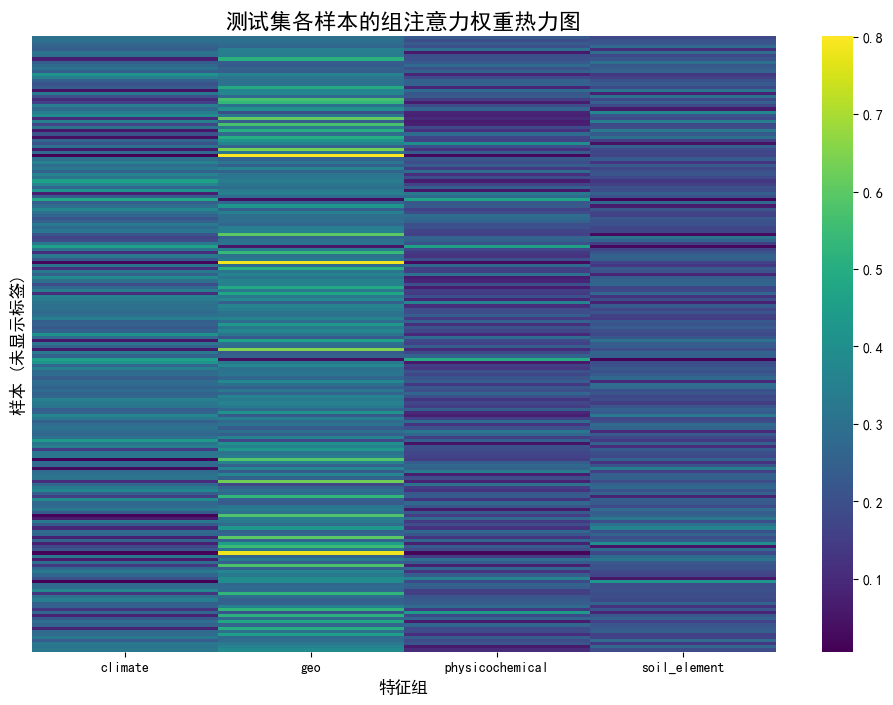

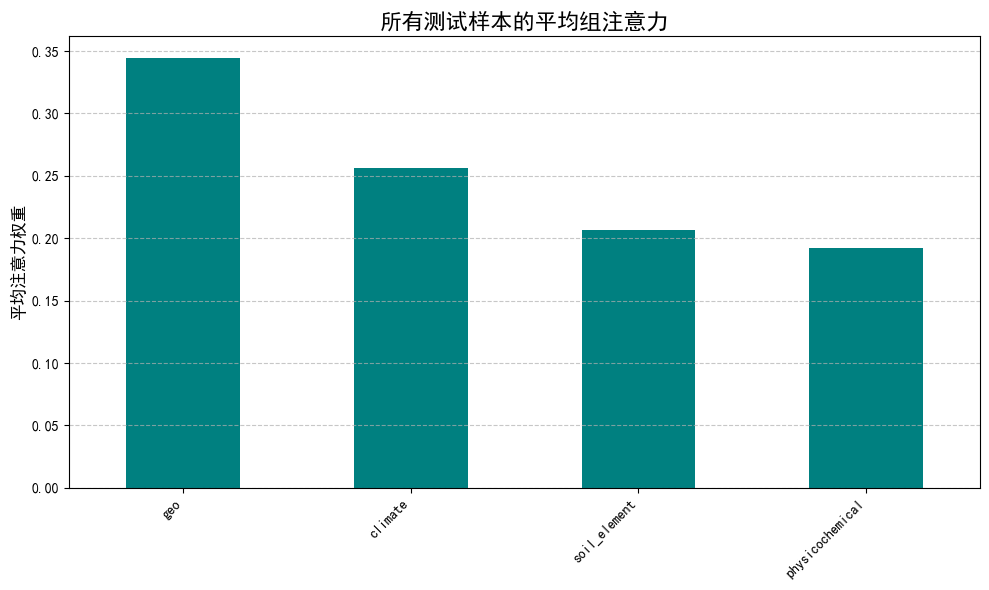


高产 vs 低产样本的平均注意力对比:
                      高产组       低产组
climate          0.293573  0.243847
geo              0.350182  0.342801
physicochemical  0.206037  0.187820
soil_element     0.150207  0.225532


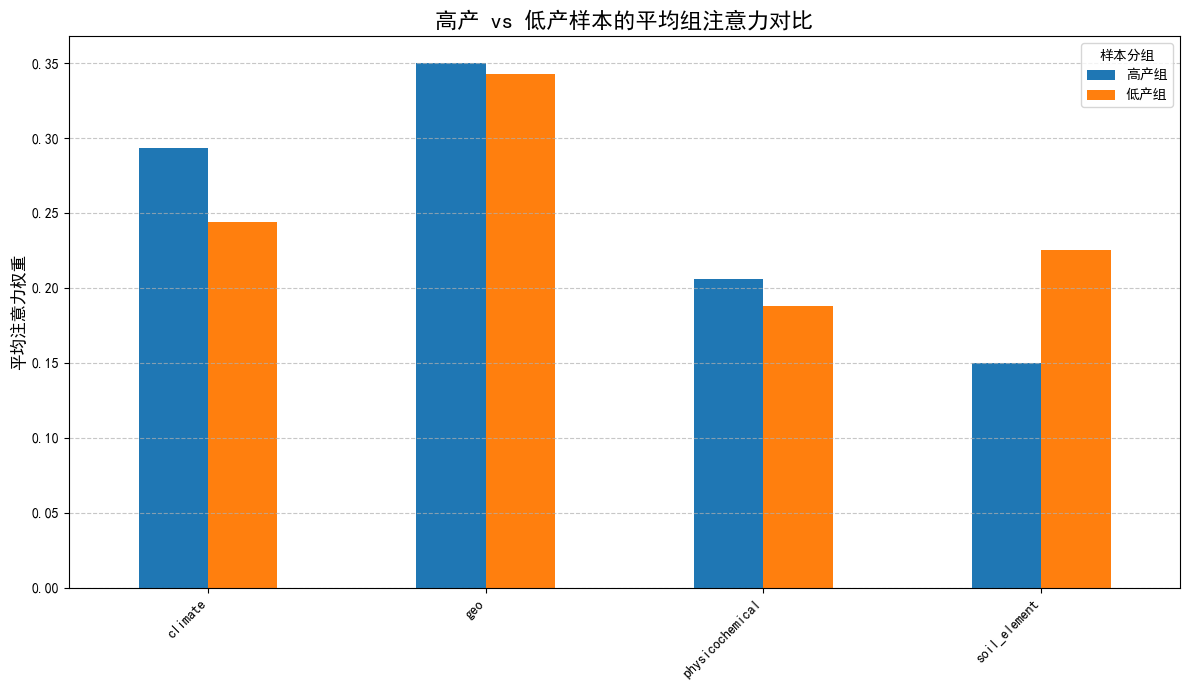

In [19]:
# 1. 获取测试集的注意力分数
# test_pred_outputs 是一个列表: [reconstruction, prediction, attention_scores]
_, _, test_attention_scores = test_pred_outputs

# 2. 将分数和组名对应起来，创建DataFrame
group_names = list(feature_groups.keys())
attention_df = pd.DataFrame(test_attention_scores, columns=group_names, index=X_test.index)

print("=" * 50)
print("动态组注意力分析:")
print("=" * 50)
print("测试集样本的注意力分数 (前5个样本):")
print(attention_df.head())

# 3. 可视化注意力分数

# a. 绘制注意力分数的整体分布热力图
plt.figure(figsize=(12, 8))
sns.heatmap(attention_df, cmap='viridis', xticklabels=True, yticklabels=False)
plt.title('测试集各样本的组注意力权重热力图', fontsize=16)
plt.xlabel('特征组', fontsize=12)
plt.ylabel('样本 (未显示标签)', fontsize=12)
plt.show()

# b. 绘制平均注意力重要性
mean_attention = attention_df.mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
mean_attention.plot(kind='bar', color='teal')
plt.title('所有测试样本的平均组注意力', fontsize=16)
plt.ylabel('平均注意力权重', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# c. 分析高产/低产样本的注意力差异 (示例)
# 合并预测结果和注意力分数
y_test_pred_df = pd.DataFrame(test_target_pred_orig, index=X_test.index, columns=['predicted_value'])
attention_with_pred = pd.concat([attention_df, y_test_pred_df], axis=1)

# 根据预测值定义高产和低产组
quantile_threshold = attention_with_pred['predicted_value'].quantile(0.75)
high_yield_samples = attention_with_pred[attention_with_pred['predicted_value'] >= quantile_threshold]
low_yield_samples = attention_with_pred[attention_with_pred['predicted_value'] < quantile_threshold]

# 计算并比较两组的平均注意力
mean_attn_high = high_yield_samples[group_names].mean().rename('高产组')
mean_attn_low = low_yield_samples[group_names].mean().rename('低产组')
comparison_df = pd.concat([mean_attn_high, mean_attn_low], axis=1)

print("\n高产 vs 低产样本的平均注意力对比:")
print(comparison_df)

# 绘制对比图
comparison_df.plot(kind='bar', figsize=(12, 7))
plt.title('高产 vs 低产样本的平均组注意力对比', fontsize=16)
plt.ylabel('平均注意力权重', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='样本分组')
plt.tight_layout()
plt.show()

In [ ]:
# 从训练好的GSDAE模型中按名称获取组选择层的实例
group_selective_layer_instance = GSDAE.get_layer('improved_group_selective_layer')

# 使用RMS（L2范数并归一化）作为组评分标准进行分析
sorted_groups_raw, feature_importance, weights = analyze_feature_importance(
    group_selective_layer_instance, 
    feature_groups, # 注意：这里使用的是最后一次实验的 feature_groups
    feature_names,
    metric='l2', 
    normalize=True
)

print("=" * 50)
print("最终模型 - 特征重要性分析:")
print("=" * 50)
print("\n特征组重要性排名 (RMS):")
for i, (group_name, importance) in enumerate(sorted_groups_raw):
    print(f"{i+1:2d}. {group_name:12s}: {importance:.4f}")

print("\n各组内关键特征 (前3个):")
for group_name, features in feature_importance.items():
    print(f"\n{group_name}:")
    for i, (feat_name, weight) in enumerate(features[:3]):
        print(f"  {i+1}. {feat_name}: {weight:.4f}")

最终模型 - 特征重要性分析:

特征组重要性排名 (RMS):
 1. soil_element: 0.4429
 2. physicochemical: 0.2001
 3. climate     : 0.1896
 4. geo         : 0.1675

各组内关键特征 (前3个):

climate:
  1. MI: 0.8606
  2. DI: 0.8019
  3. MTWA: 0.7231

geo:
  1. Landscape_Mountain: 0.8639
  2. Latitude: 0.8364
  3. ALT_extract: 0.8299

physicochemical:
  1. Landscape_Mountain: 0.8639
  2. pH: 0.8291
  3. SoilType_Roam: 0.7206

soil_element:
  1. Cu_S: 0.9707
  2. Ga_S: 0.9408
  3. La_S: 0.9327


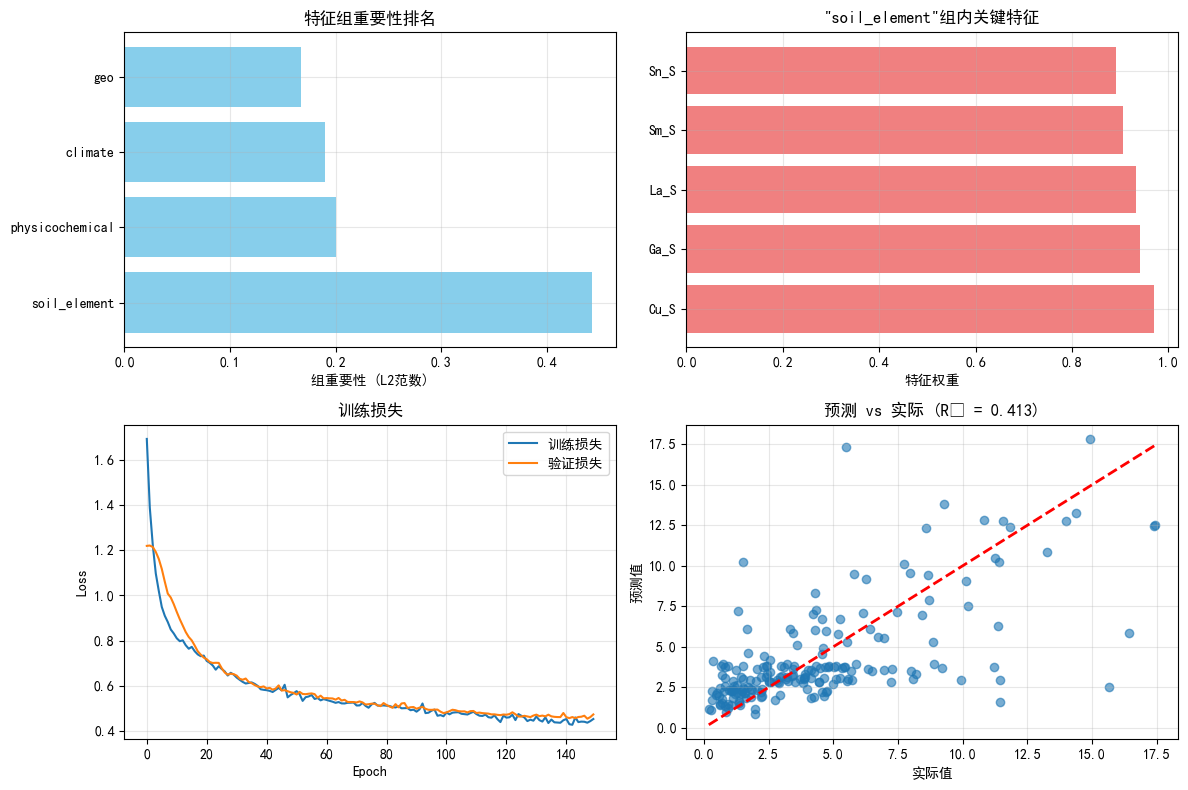

In [ ]:
# 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 组重要性
top_n_groups = min(8, len(sorted_groups_raw))
groups = [item[0] for item in sorted_groups_raw[:top_n_groups]]
importance = [item[1] for item in sorted_groups_raw[:top_n_groups]]

axes[0, 0].barh(groups, importance, color='skyblue')
axes[0, 0].set_xlabel('组重要性 (L2范数)')
axes[0, 0].set_title('特征组重要性排名')
axes[0, 0].grid(True, alpha=0.3)

# 最重要组的关键特征
if sorted_groups_raw:
    top_group = sorted_groups_raw[0][0]
    top_features = feature_importance[top_group][:5]
    
    feature_names_short = [item[0][:15] + '...' if len(item[0]) > 15 else item[0] for item in top_features]
    feature_weights = [item[1] for item in top_features]
    
    axes[0, 1].barh(feature_names_short, feature_weights, color='lightcoral')
    axes[0, 1].set_xlabel('特征权重')
    axes[0, 1].set_title(f'"{top_group}"组内关键特征')
    axes[0, 1].grid(True, alpha=0.3)

# 训练损失
axes[1, 0].plot(history_gsdae.history['loss'], label='训练损失')
axes[1, 0].plot(history_gsdae.history['val_loss'], label='验证损失')
axes[1, 0].set_title('训练损失')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 预测准确性
axes[1, 1].scatter(y_test_orig, test_target_pred_orig, alpha=0.6)
axes[1, 1].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('实际值')
axes[1, 1].set_ylabel('预测值')
axes[1, 1].set_title(f'预测 vs 实际 (R² = {test_r2:.3f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary\n
\n
### GSDAE模型总结\n
\n
本notebook实现了基于方案文档的GSDAE模型，主要改进包括：\n
\n
1. **组稀疏正则化**: 针对生态因子的天然分组结构\n
2. **半监督学习**: 引入丹参酮含量作为监督信号\n
3. **预测头**: 专门的预测分支用于药效成分含量预测\n
4. **复合损失函数**: 重构误差 + 预测误差 + 组稀疏正则化\n
5. **两层重要性分析**: 组重要性评估 + 组内关键特征识别\n
\n
### 模型优势\n
\n
- **生物学意义**: 特征分组符合生态因子的天然结构\n
- **目标导向**: 半监督学习机制与药效预测任务对齐\n
- **可解释性**: 提供宏观到微观的多层次分析结果\n
- **实用性**: 同时完成特征选择、降维和预测任务

#### 绘制图


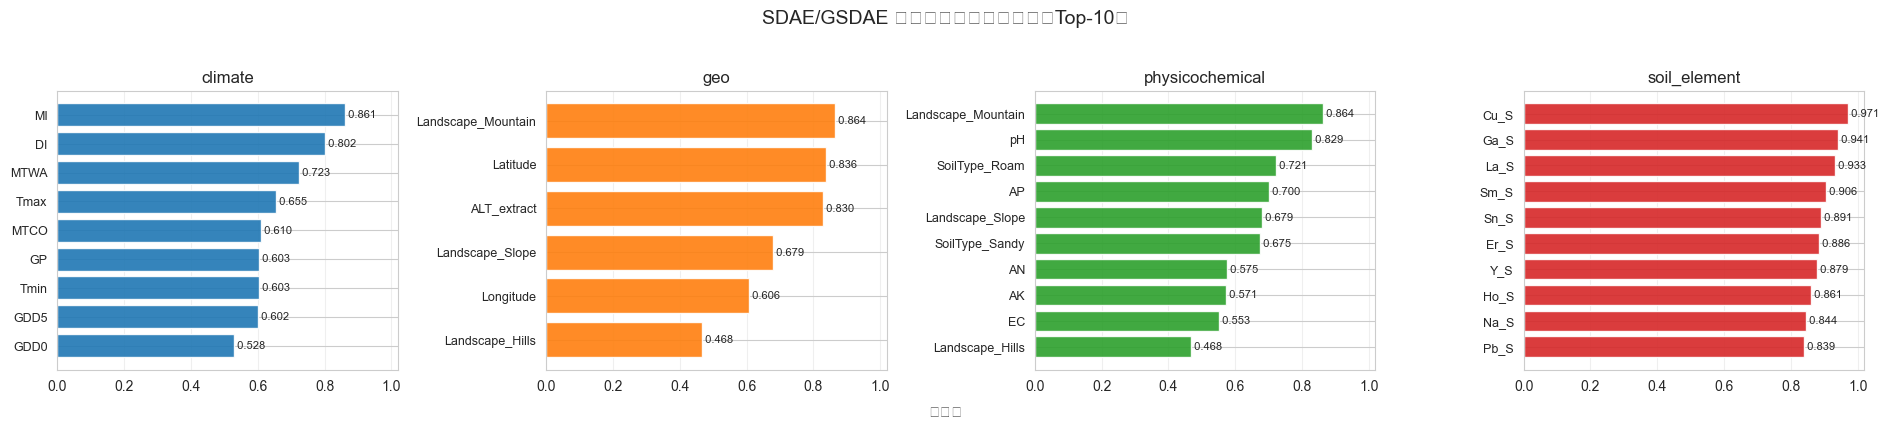

In [22]:
# 可视化：各特征组 Top-10 特征权重分布面板（类似图1）
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

sns.set_style("whitegrid")

def _get_layer_kernel(layer):
    if hasattr(layer, "kernel") and layer.kernel is not None:
        w = layer.kernel.numpy()
        return np.asarray(w, dtype=float)
    raise ValueError("layer 不含 kernel 权重，请确认传入的是 GroupSelectiveLayer/ImprovedGroupSelectiveLayer 的实例。")

def compute_group_feature_weights(layer, feature_groups, feature_names):
    """返回 {组名: [(特征名, 权重), ...]}"""
    weights = _get_layer_kernel(layer)
    result = {}
    for g, idx in feature_groups.items():
        if len(idx) == 0:
            continue
        pairs = [(feature_names[i], float(weights[i])) for i in idx]
        # 只保留非负权重（该层已约束到[0,1]，此处为稳健性）
        pairs = [(n, max(0.0, w)) for n, w in pairs]
        result[g] = pairs
    return result

def plot_group_weight_panels(group_feature_weights, top_k=10, group_order=None, ncols=4):
    """绘制各组Top-K特征权重面板"""
    # 组显示顺序
    keys = list(group_feature_weights.keys())
    if group_order:
        ordered = [g for g in group_order if g in group_feature_weights] + [g for g in keys if g not in group_order]
    else:
        ordered = keys

    ordered_map = OrderedDict((g, group_feature_weights[g]) for g in ordered)
    ng = len(ordered_map)
    ncols = min(ncols, max(1, ng))
    nrows = int(np.ceil(ng / ncols))

    # 统一x轴上限，便于对比
    global_max = 0.0
    for feats in ordered_map.values():
        if feats:
            global_max = max(global_max, max(w for _, w in feats))
    global_max = max(global_max, 1e-6) * 1.05

    # 颜色：每组一个主色
    palette = sns.color_palette("tab10", n_colors=max(10, ng))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.6*ncols+0.6, 3.2*nrows+1), squeeze=False, sharex=True)
    ax_list = axes.flatten()

    # 先关掉所有坐标轴，避免空格子显示框线
    for ax in ax_list:
        ax.axis("off")

    for i, (g, feats) in enumerate(ordered_map.items()):
        ax = ax_list[i]
        ax.axis("on")
        feats_sorted = sorted(feats, key=lambda x: x[1], reverse=True)[:top_k]
        # 反向画水平条，便于从上到下显示从小到大
        names = [n if len(n) <= 18 else n[:18] + "…" for n, _ in feats_sorted][::-1]
        vals = [v for _, v in feats_sorted][::-1]

        ax.barh(names, vals, color=palette[i % len(palette)], alpha=0.9)
        ax.set_title(g, fontsize=12, pad=6)
        ax.set_xlim(0, global_max)
        ax.grid(True, axis='x', alpha=0.3)
        ax.tick_params(axis='y', labelsize=9)

        # 数值标注
        for y, v in enumerate(vals):
            ax.text(v, y, f" {v:.3f}", va='center', ha='left', fontsize=8)

    # 总标题与公共x轴标签
    fig.suptitle("SDAE/GSDAE 各特征组权重分布（每组Top-10）", fontsize=14)
    fig.text(0.5, 0.01, "权重值", ha='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 使用示例（训练完成后运行）
# 从训练好的GSDAE模型中按名称获取组选择层的实例
try:
    layer_inst = GSDAE.get_layer('improved_group_selective_layer')
    if layer_inst is None:
        raise RuntimeError("在GSDAE模型中未找到名为 'improved_group_selective_layer' 的层。")
except NameError:
    raise NameError("模型 'GSDAE' 未定义。请确保前面的模型训练单元格已成功运行。")


group_feature_weights = compute_group_feature_weights(layer_inst, feature_groups, feature_names)

# 推荐的组显示顺序（若某组不存在会自动跳过）
preferred_order = ["土壤元素", "作物元素", "土壤养分", "地理信息", "气候环境",
                   "省份", "城市", "地貌", "土壤类型", "栽培类型", "气候类型"]

plot_group_weight_panels(group_feature_weights, top_k=10, group_order=preferred_order, ncols=4)

已设置中文字体: Microsoft YaHei


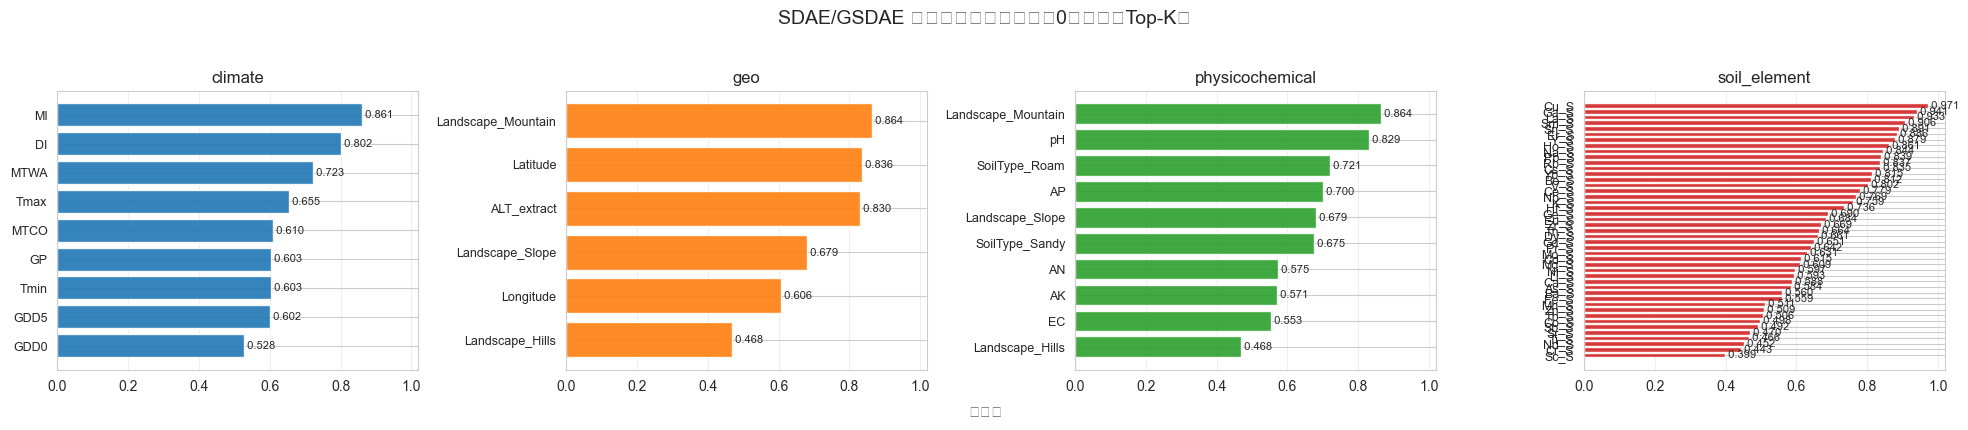

In [23]:
# 中文字体与“0权重可见”的权重面板图
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from matplotlib import font_manager as fm
from matplotlib.font_manager import FontProperties

def set_cn_font():
    """自动注册并启用中文字体"""
    candidates = [
        r"C:\Windows\Fonts\msyh.ttc",   # 微软雅黑
        r"C:\Windows\Fonts\msyh.ttf",
        r"C:\Windows\Fonts\simhei.ttf", # 黑体
        r"C:\Windows\Fonts\simsun.ttc"  # 宋体
    ]
    chosen = None
    for p in candidates:
        if os.path.exists(p):
            try:
                fm.fontManager.addfont(p)
                chosen = FontProperties(fname=p).get_name()
                break
            except Exception:
                pass
    if chosen is None:
        # 回退到常用名称
        chosen = "Microsoft YaHei"
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [chosen, 'SimHei', 'SimSun', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    print(f"已设置中文字体: {chosen}")

set_cn_font()
sns.set_style("whitegrid")

def _get_layer_kernel(layer):
    if hasattr(layer, "kernel") and layer.kernel is not None:
        w = layer.kernel.numpy()
        return np.asarray(w, dtype=float)
    raise ValueError("layer 不含 kernel 权重，请确认传入的是 GroupSelectiveLayer/ImprovedGroupSelectiveLayer 的实例。")

def compute_group_feature_weights(layer, feature_groups, feature_names):
    """返回 {组名: [(特征名, 权重), ...]}（包含0值）"""
    weights = _get_layer_kernel(layer)
    result = {}
    for g, idx in feature_groups.items():
        
        if len(idx) == 0:
            continue
        pairs = [(feature_names[i], float(max(0.0, weights[i]))) for i in idx]  # 负值截断为0，保留0
        result[g] = pairs
    return result

def plot_group_weight_panels(group_feature_weights, top_k=None, group_order=None, ncols=4, zero_min_ratio=0.02):
    """
    绘制各组Top-K特征权重面板
    - top_k=None 显示组内全部特征
    - zero_min_ratio: 0值条形显示为 (global_max * ratio) 的最小宽度
    """
    # 组显示顺序
    keys = list(group_feature_weights.keys())
    if group_order:
        ordered = [g for g in group_order if g in group_feature_weights] + [g for g in keys if g not in group_order]
    else:
        ordered = keys

    ordered_map = OrderedDict((g, group_feature_weights[g]) for g in ordered)
    ng = len(ordered_map)
    ncols = min(ncols, max(1, ng))
    nrows = int(np.ceil(ng / ncols))

    # 统一x轴上限，便于对比（按真实权重计算）
    all_vals = [w for feats in ordered_map.values() for _, w in feats] or [0.0]
    global_max = float(max(all_vals))
    if global_max <= 0:
        global_max = 1.0  # 全0时的可视上限
    xlim = global_max * 1.05
    min_bar = max(global_max * zero_min_ratio, 1e-6)  # 0值条的最小显示宽度

    palette = sns.color_palette("tab10", n_colors=max(10, ng))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols+0.6, 3.2*nrows+1), squeeze=False, sharex=True)
    ax_list = axes.flatten()

    # 先关掉所有坐标轴，避免空格子显示框线
    for ax in ax_list:
        ax.axis("off")

    for i, (g, feats) in enumerate(ordered_map.items()):
        ax = ax_list[i]
        ax.axis("on")
        feats_sorted = sorted(feats, key=lambda x: x[1], reverse=True)
        if top_k is not None:
            feats_sorted = feats_sorted[:top_k]

        names = [n if len(n) <= 18 else n[:18] + "…" for n, _ in feats_sorted][::-1]
        vals_true = [v for _, v in feats_sorted][::-1]
        # 0值条形使用最小宽度渲染，但保留真实数值标注
        vals_plot = [v if v > 0 else min_bar for v in vals_true]

        ax.barh(names, vals_plot, color=palette[i % len(palette)], alpha=0.9)
        ax.set_title(g, fontsize=12, pad=6)
        ax.set_xlim(0, xlim)
        ax.grid(True, axis='x', alpha=0.3)
        ax.tick_params(axis='y', labelsize=9)

        # 数值标注（使用真实值；位置用绘制宽度以保证可见）
        for y, (vp, vt) in enumerate(zip(vals_plot, vals_true)):
            ax.text(vp, y, f" {vt:.3f}", va='center', ha='left', fontsize=8)

    fig.suptitle("SDAE/GSDAE 各特征组权重分布（含0值；每组Top-K）", fontsize=14)
    fig.text(0.5, 0.01, "权重值", ha='center', fontsize=11)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
# 从训练好的GSDAE模型中按名称获取组选择层的实例
try:
    layer_inst = GSDAE.get_layer('improved_group_selective_layer')
    if layer_inst is None:
        raise RuntimeError("在GSDAE模型中未找到名为 'improved_group_selective_layer' 的层。")
except NameError:
    raise NameError("模型 'GSDAE' 未定义。请确保前面的模型训练单元格已成功运行。")


group_feature_weights = compute_group_feature_weights(layer_inst, feature_groups, feature_names)
# 推荐顺序；top_k=None 显示组内全部特征（包含0）
preferred_order = ["土壤元素", "作物元素", "土壤养分", "地理信息", "气候环境",
                   "省份", "城市", "地貌", "土壤类型", "栽培类型", "气候类型"]

plot_group_weight_panels(group_feature_weights, top_k=None, group_order=preferred_order, ncols=4, zero_min_ratio=0.02)

分组重要性（已按行归一化，已排除 all_env）:


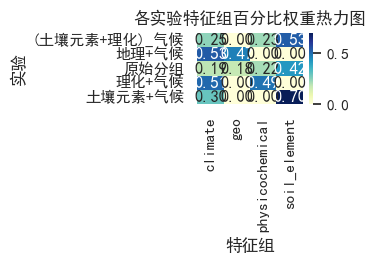

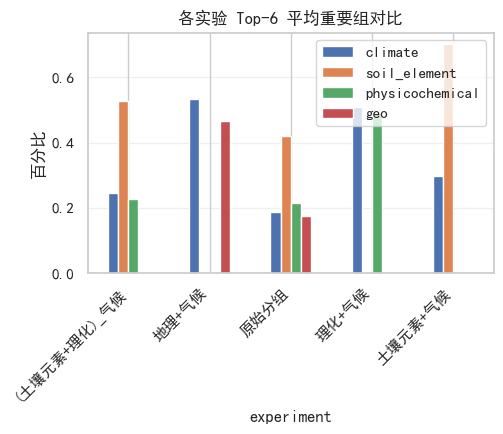

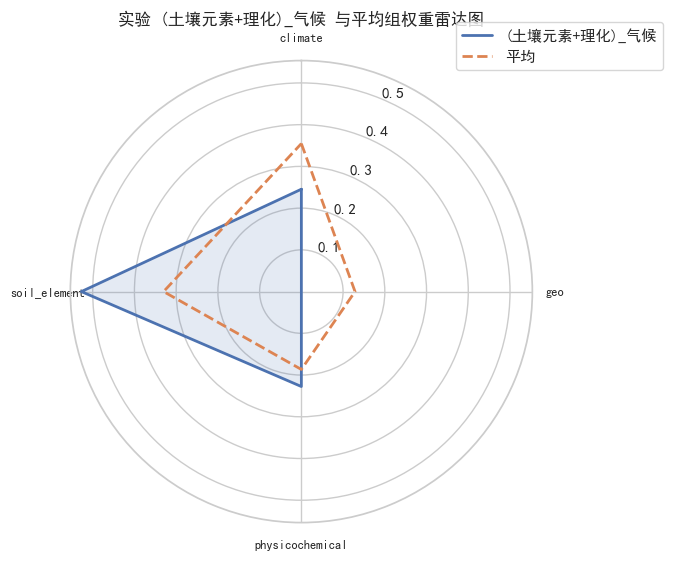

In [5]:
fenzu_root = os.path.join("results", "fenzu")
summary_files = []
for d in sorted(os.listdir(fenzu_root)):
    exp_dir = os.path.join(fenzu_root, d)
    mf = os.path.join(exp_dir, "model_summary.txt")
    if os.path.isfile(mf):
        summary_files.append(mf)

if not summary_files:
    print("未找到任何 model_summary.txt，确认已运行批量实验。")

def parse_group_importance(path):
    exp_name = None
    groups = {}
    with open(path, 'r', encoding='utf-8') as f:
        lines = [l.strip() for l in f.readlines()]
    for l in lines:
        if l.startswith("实验:"):
            exp_name = l.split("实验:")[-1].strip()
            break
    if exp_name and ('all_env' in exp_name.lower()):
        return exp_name, {}  # 直接跳过
    start_idx = None
    for i,l in enumerate(lines):
        if "特征组重要性" in l:
            start_idx = i+1
            break
    if start_idx is None:
        return exp_name or os.path.basename(os.path.dirname(path)), {}
    for l in lines[start_idx:]:
        if not l or re.match(r"各组内前3特征", l):
            break
        m = re.match(r"\d+\.\s*(.+?):\s*([0-9.]+)", l)
        if m:
            gname = m.group(1).strip()
            val = float(m.group(2))
            groups[gname] = val
    return exp_name or os.path.basename(os.path.dirname(path)), groups

# 构建 records 时自动跳过 all_env 空字典
records = []
all_groups = set()
for fp in summary_files:
    exp, gdict = parse_group_importance(fp)
    if gdict and ('all_env' not in exp.lower()):
        all_groups.update(gdict.keys())
        records.append((exp, gdict))

# DataFrame
df_rows = []
for exp, gdict in records:
    row = {g: gdict.get(g, 0.0) for g in all_groups}
    s = sum(row.values())
    if s > 0:
        row = {g: v / s for g, v in row.items()}
    row['experiment'] = exp
    df_rows.append(row)

importance_df = pd.DataFrame(df_rows).set_index('experiment').sort_index()
importance_df = importance_df[sorted(importance_df.columns)]
# 再次保险过滤
importance_df = importance_df[~importance_df.index.str.contains(r'(^all_env$)|all_env', regex=True)]
print("分组重要性（已按行归一化，已排除 all_env）:")

# 在构建 importance_df 之后、开始绘图之前加入：英文实验名到中文的映射
cn_exp_map = {
    "original_groups": "原始分组",
    "physicochemical_climate": "理化+气候",
    "soil_element_climate": "土壤元素+气候",
    "geo_climate": "地理+气候",
    "soil_element_physicochemical_climate": "土壤元素+理化+气候",
    "(soil_element_physicochemical)_climate": "(土壤元素+理化)_气候"
}
# 若解析出的实验名在映射里则替换；不在映射里保持原样
importance_df.rename(index=cn_exp_map, inplace=True)

# 1. 热力图
plt.figure(figsize=(1.2+0.6*len(importance_df.columns), 0.8+0.4*len(importance_df)))
sns.heatmap(importance_df, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title("各实验特征组百分比权重热力图")
plt.xlabel("特征组")
plt.ylabel("实验")
plt.tight_layout()
plt.show()



# 3. 分组柱状（前 N 重要组交叉对比）
topK = 6
# 计算全局平均并选前K
global_mean = importance_df.mean(axis=0).sort_values(ascending=False).head(topK).index
bar_df = importance_df[global_mean]
fig, ax = plt.subplots(figsize=(1.2+0.8*len(bar_df.index), 4.5))
bar_df.plot(kind='bar', ax=ax)
ax.set_ylabel("百分比")
ax.set_title(f"各实验 Top-{topK} 平均重要组对比")
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. 若需雷达图展示单个实验与平均分布：
def plot_radar(single_exp, df):
    from math import pi
    cats = list(df.columns)
    vals = df.loc[single_exp, cats].tolist()
    avg = df.mean().loc[cats].tolist()
    angles = [n/float(len(cats))*2*pi for n in range(len(cats))]
    angles += angles[:1]
    vals += vals[:1]
    avg += avg[:1]
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], cats, fontsize=9)
    ax.plot(angles, vals, linewidth=2, label=single_exp)
    ax.fill(angles, vals, alpha=0.15)
    ax.plot(angles, avg, linewidth=2, linestyle='--', label='平均')
    ax.set_title(f"实验 {single_exp} 与平均组权重雷达图")
    plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
    plt.show()

# 示例：绘制第一行实验的雷达
if len(importance_df.index) > 0:
    plot_radar(importance_df.index[0], importance_df)


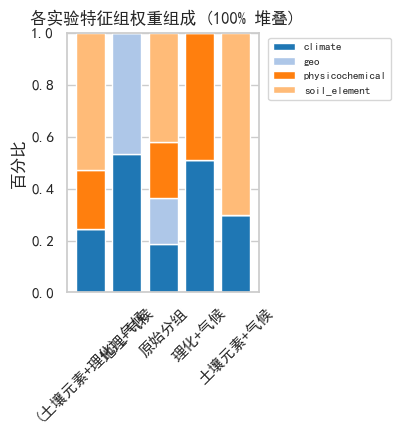

In [6]:
# 2. 100% 堆叠条形图
fig, ax = plt.subplots(figsize=(1.2+0.6*len(importance_df.index), 4.5))
bottom = None
colors = sns.color_palette("tab20", n_colors=len(importance_df.columns))
for i, g in enumerate(importance_df.columns):
    vals = importance_df[g].values
    if bottom is None:
        ax.bar(importance_df.index, vals, label=g, color=colors[i])
        bottom = vals.copy()
    else:
        ax.bar(importance_df.index, vals, bottom=bottom, label=g, color=colors[i])
        bottom += vals
ax.set_ylim(0,1)
ax.set_ylabel("百分比")
ax.set_title("各实验特征组权重组成 (100% 堆叠)")
ax.tick_params(axis='x', rotation=45)
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

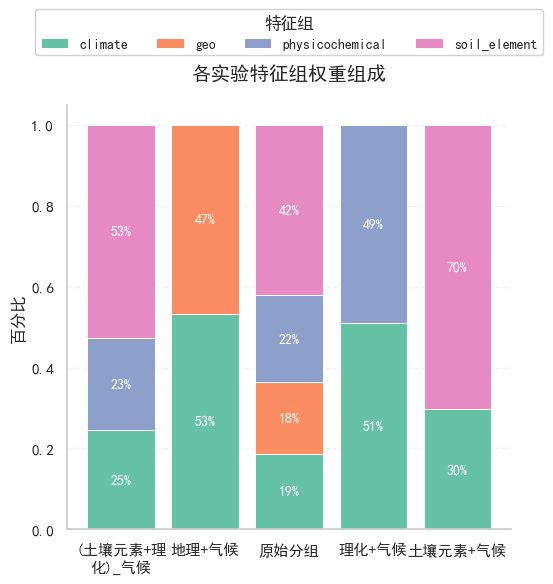

In [8]:
sns.set_theme(
    style="whitegrid", 
    font='SimHei',  # Windows用 SimHei, Mac用 Arial Unicode MS
    rc={'axes.unicode_minus': False}
)
def wrap_label(s, width=7):
    # 按字符宽度简单换行
    return "\n".join([s[i:i+width] for i in range(0, len(s), width)])

# 准备数据（importance_df 已行归一化且索引为中文实验名）
bar_df = importance_df.copy()
bar_df.index = [wrap_label(x) for x in bar_df.index]

colors = sns.color_palette("Set2", n_colors=len(bar_df.columns))

fig, ax = plt.subplots(figsize=(1.2+0.9*len(bar_df.index), 5.8))
bottom = np.zeros(len(bar_df.index))

for i, col in enumerate(bar_df.columns):
    vals = bar_df[col].values
    bars = ax.bar(bar_df.index, vals, bottom=bottom,
                  label=col, color=colors[i], edgecolor="white", linewidth=0.7)
    for (x, b, v, bi) in zip(bar_df.index, bars, vals, range(len(vals))):
        if v >= 0.05:
            ax.text(b.get_x()+b.get_width()/2,
                    bottom[bi] + v/2,
                    f"{v*100:.0f}%",
                    ha="center", va="center",
                    color="white", fontsize=10, fontweight="bold")
    bottom += vals

ax.set_ylim(0, 1.05)
ax.set_ylabel("百分比", fontsize=12)
ax.set_title("各实验特征组权重组成", fontsize=14, fontweight="bold", pad=18)

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

plt.xticks(rotation=0, fontsize=11)
ax.grid(axis="y", alpha=0.25, linestyle="--")
ax.grid(axis="x", visible=False)

# 动态计算图例需要的垂直空间
legend_ncol = min(4, len(bar_df.columns))
legend_rows = int(np.ceil(len(bar_df.columns) / legend_ncol))
legend_extra = 0.05 + 0.05 * legend_rows   # 行数越多越往上
leg = ax.legend(
    ncol=legend_ncol,
    bbox_to_anchor=(0.5, 1.0 + legend_extra),
    loc="lower center",
    frameon=True,
    fontsize=10,
    title="特征组"
)
leg.get_frame().set_alpha(0.9)

plt.tight_layout()
# 再次手动增加顶部空间避免标题与图例挤压
plt.subplots_adjust(top=0.78 + 0.06 * legend_rows)

plt.show()

In [7]:
def _parse_group_importance(path):
    exp_name = None
    groups = {}
    with open(path, 'r', encoding='utf-8') as f:
        lines = [l.strip() for l in f.readlines()]
    for l in lines:
        if l.startswith("实验:"):
            exp_name = l.split("实验:")[-1].strip()
            break
    # 跳过 all_env
    if exp_name and ('all_env' in exp_name.lower()):
        return exp_name, {}
    start_idx = None
    for i,l in enumerate(lines):
        if "特征组重要性" in l:
            start_idx = i+1
            break
    if start_idx is None:
        return exp_name or os.path.basename(os.path.dirname(path)), {}
    for l in lines[start_idx:]:
        if not l or re.match(r"各组内前3特征", l):
            break
        m = re.match(r"\d+\.\s*(.+?):\s*([0-9.]+)", l)
        if m:
            gname = m.group(1).strip()
            val = float(m.group(2))
            groups[gname] = val
    return exp_name or os.path.basename(os.path.dirname(path)), groups

def ensure_importance_df(normalize_rows=True):
    # 始终从磁盘重建，不再复用内存中的 importance_df
    fenzu_root = os.path.join("results", "fenzu")
    if not os.path.isdir(fenzu_root):
        raise FileNotFoundError("未找到结果目录: results/fenzu")

    # 收集实验目录
    exp_dirs = []
    for d in sorted(os.listdir(fenzu_root)):
        exp_dir = os.path.join(fenzu_root, d)
        if os.path.isdir(exp_dir):
            exp_dirs.append(exp_dir)
    if not exp_dirs:
        raise FileNotFoundError("未找到任何实验目录，请先运行批量实验。")

    # 解析函数：仅提取“实验名”
    def _parse_exp_name_from_summary(path):
        try:
            with open(path, 'r', encoding='utf-8') as f:
                for l in f:
                    l = l.strip()
                    if l.startswith("实验:"):
                        return l.split("实验:")[-1].strip()
        except Exception:
            pass
        return os.path.basename(os.path.dirname(path))

    records = []
    all_groups = set()
    for exp_dir in exp_dirs:
        raw_csv = os.path.join(exp_dir, "group_importance_raw.csv")
        summary_txt = os.path.join(exp_dir, "model_summary.txt")
        if not os.path.isfile(summary_txt):
            # 没有summary就用目录名
            exp_name = os.path.basename(exp_dir)
        else:
            exp_name = _parse_exp_name_from_summary(summary_txt)
        # 跳过 all_env
        if exp_name and ('all_env' in exp_name.lower()):
            continue

        gdict = {}
        if os.path.isfile(raw_csv):
            try:
                df = pd.read_csv(raw_csv)
                for _, row in df.iterrows():
                    gdict[str(row["group"])] = float(row["value"])
            except Exception:
                pass
        else:
            # 回退：从文本里解析 Raw 段（若存在），否则解析百分比段
            try:
                with open(summary_txt, 'r', encoding='utf-8') as f:
                    lines = [l.strip() for l in f.readlines()]
                # 先找 Raw 段
                start = None
                for i, l in enumerate(lines):
                    if "特征组重要性 (Raw" in l:
                        start = i + 1
                        break
                end = None
                if start is not None:
                    for j in range(start, len(lines)):
                        if not lines[j] or "特征组重要性 (" in lines[j] or "各组内前3特征" in lines[j]:
                            end = j
                            break
                    if end is None:
                        end = len(lines)
                    for l in lines[start:end]:
                        m = re.match(r"\d+\.\s*(.+?):\s*([0-9.]+)", l)
                        if m:
                            gdict[m.group(1).strip()] = float(m.group(2))
                # 如果 Raw 没解析到，则解析百分比段
                if not gdict:
                    start = None
                    for i, l in enumerate(lines):
                        if "特征组重要性 (百分比" in l or "特征组重要性 (前10)" in l:
                            start = i + 1
                            break
                    if start is not None:
                        for j in range(start, len(lines)):
                            if not lines[j] or "各组内前3特征" in lines[j]:
                                end = j
                                break
                        if end is None:
                            end = len(lines)
                        for l in lines[start:end]:
                            m = re.match(r"\d+\.\s*(.+?):\s*([0-9.]+)", l)
                            if m:
                                gdict[m.group(1).strip()] = float(m.group(2))
            except Exception:
                pass

        if gdict:
            all_groups.update(gdict.keys())
            records.append((exp_name, gdict))

    if not records:
        raise FileNotFoundError("未解析到任何组重要性条目，请确认已保存 group_importance_raw.csv 或 summary。")

    # 构建 DataFrame
    df_rows = []
    for exp, gdict in records:
        row = {g: gdict.get(g, 0.0) for g in all_groups}
        if normalize_rows:
            s = sum(row.values())
            if s > 0:
                row = {g: v / s for g, v in row.items()}
        row["experiment"] = exp
        df_rows.append(row)

    df = pd.DataFrame(df_rows).set_index("experiment")

    cn_exp_map = {
        "original_groups": "原始分组",
        "physicochemical_climate": "理化+气候",
        "soil_element_climate": "土壤元素+气候",
        "geo_climate": "地理+气候",
        "soil_element_physicochemical_climate": "土壤元素+理化+气候",
        "(soil_element_physicochemical)_climate": "(土壤元素+理化)_气候"
    }
    df.rename(index=cn_exp_map, inplace=True)
    order = df.mean(axis=0).sort_values(ascending=False).index
    df = df[order]
    return df

# 构建/获取 importance_df（未归一化原始数值）
imp_df = ensure_importance_df(normalize_rows=False)
imp_raw = imp_df.round(6)

print("所有实验分组的特征重要性（原始数值，未归一化）")
print(imp_raw.to_string())

# 保存 CSV（未归一化）
out_csv = os.path.join("results", "fenzu", "group_importance_values_raw.csv")
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
imp_raw.to_csv(out_csv, encoding="utf-8-sig")
print(f"\n已保存: {out_csv}")

# 可选：每个实验 Top-5（原始数值）
print("\n每个实验 Top-5 重要组（原始数值）：")
for exp, row in imp_raw.iterrows():
    top = row.sort_values(ascending=False).head(5)
    print(f"- {exp}: " + ", ".join([f"{g}:{v:.6f}" for g, v in top.items()]))
# ...existing code...

所有实验分组的特征重要性（原始数值，未归一化）
              climate  soil_element  physicochemical     geo
experiment                                                  
地理+气候          0.5332        0.0000           0.0000  0.4668
原始分组           0.1873        0.4210           0.2154  0.1763
理化+气候          0.5099        0.0000           0.4901  0.0000
土壤元素+气候        0.2975        0.7025           0.0000  0.0000
(土壤元素+理化)_气候   0.2453        0.5272           0.2275  0.0000

已保存: results\fenzu\group_importance_values_raw.csv

每个实验 Top-5 重要组（原始数值）：
- 地理+气候: climate:0.533200, geo:0.466800, soil_element:0.000000, physicochemical:0.000000
- 原始分组: soil_element:0.421000, physicochemical:0.215400, climate:0.187300, geo:0.176300
- 理化+气候: climate:0.509900, physicochemical:0.490100, soil_element:0.000000, geo:0.000000
- 土壤元素+气候: soil_element:0.702500, climate:0.297500, physicochemical:0.000000, geo:0.000000
- (土壤元素+理化)_气候: soil_element:0.527200, climate:0.245300, physicochemical:0.227500, geo:0.000000


分组重要性（原始数值，未归一化）:


,climate,soil_element,physicochemical,geo
experiment,,,,
地理+气候,0.533200,0.000000,0.000000,0.466800
原始分组,0.187300,0.421000,0.215400,0.176300
理化+气候,0.509900,0.000000,0.490100,0.000000
土壤元素+气候,0.297500,0.702500,0.000000,0.000000
(土壤元素+理化)_气候,0.245300,0.527200,0.227500,0.000000


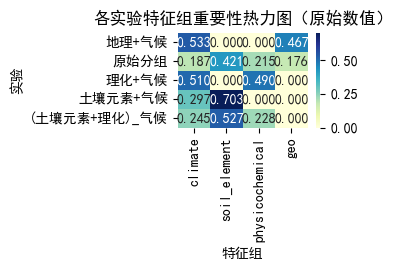

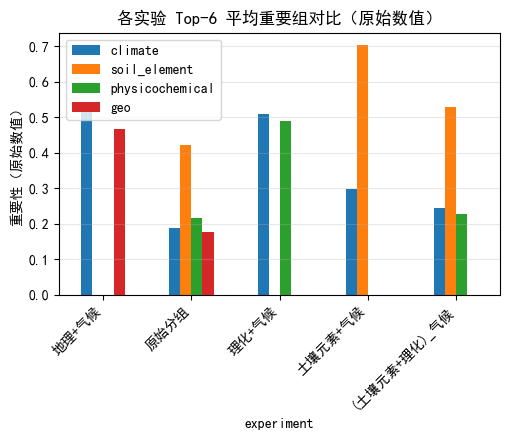

In [10]:
imp_df = ensure_importance_df(normalize_rows=False)

# 可读性：列按全局均值降序
imp_df = imp_df[imp_df.mean(axis=0).sort_values(ascending=False).index]

print("分组重要性（原始数值，未归一化）:")
from IPython.display import display
pd.set_option('display.float_format', lambda x: f'{x:.6f}')
display(imp_df)

# 1) 热力图（原始数值）
plt.figure(figsize=(1.2+0.6*len(imp_df.columns), 0.8+0.4*len(imp_df)))
sns.heatmap(imp_df, cmap='YlGnBu', annot=True, fmt='.3f')
plt.title("各实验特征组重要性热力图（原始数值）")
plt.xlabel("特征组")
plt.ylabel("实验")
plt.tight_layout()
plt.show()

# 2) 非堆叠柱状图（Top-K 原始数值）
topK = 6
global_mean_raw = imp_df.mean(axis=0).sort_values(ascending=False).head(topK).index
bar_df = imp_df[global_mean_raw]
fig, ax = plt.subplots(figsize=(1.2+0.8*len(bar_df.index), 4.5))
bar_df.plot(kind='bar', ax=ax)
ax.set_ylabel("重要性（原始数值）")
ax.set_title(f"各实验 Top-{topK} 平均重要组对比（原始数值）")
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
records = []
all_groups = set()
for fp in summary_files:
    exp, gdict = parse_group_importance(fp)
    if gdict and ('all_env' not in exp.lower()):
        all_groups.update(gdict.keys())
        records.append((exp, gdict))

df_rows = []
for exp, gdict in records:
    # 直接保留原始值
    row = {g: gdict.get(g, 0.0) for g in all_groups}
    row['experiment'] = exp
    df_rows.append(row)

importance_df_raw = pd.DataFrame(df_rows).set_index('experiment').sort_index()
importance_df_raw = importance_df_raw[sorted(importance_df_raw.columns)]
importance_df_raw = importance_df_raw[~importance_df_raw.index.str.contains(r'(^all_env$)|all_env', regex=True)]

# 映射中文名
cn_exp_map = {
    "original_groups": "原始分组",
    "physicochemical_climate": "理化+气候",
    "soil_element_climate": "土壤元素+气候",
    "geo_climate": "地理+气候",
    "soil_element_physicochemical_climate": "土壤元素+理化+气候",
    "(soil_element_physicochemical)_climate": "(土壤元素+理化)_气候"
}
importance_df_raw.rename(index=cn_exp_map, inplace=True)

print("原始组重要性（未归一化，行和不为1）:")
print(importance_df_raw.head())

# 行和检查（若接近1说明还用了旧的归一化 DataFrame）
row_sums = importance_df_raw.sum(axis=1)
print("\n行和检查:")
print(row_sums.head())

# 可视化原始值
plt.figure(figsize=(1.2+0.6*len(importance_df_raw.columns), 0.8+0.4*len(importance_df_raw)))
sns.heatmap(importance_df_raw, cmap='YlGnBu', annot=True, fmt='.3f')
plt.title("各实验特征组重要性热力图（原始值 L2）")
plt.xlabel("特征组")
plt.ylabel("实验")
plt.tight_layout()
plt.show()

NameError: name 'summary_files' is not defined